In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import torch
from torch import nn, optim

from miv.data.data_class import TrainDataSet
from miv.data.merror_funcs import get_merror_func
from miv.util import dotdict
from numpy.random import default_rng

## data preparation

In [2]:
data = pd.read_csv('rainfall_merror_df.csv')
data['date'] = pd.to_datetime(data['year'])
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['year_from_1980'] = data['date'].dt.year - 1980
data_inp = data.drop(columns=['day', 'month', 'year', 'date', 'Unnamed: 0'])
data_inp_wo_war_prio = data_inp.drop(columns=['war_prio'])


## data playground

In [2]:
data = pd.read_csv('rainfall_merror_df.csv')
data.head(-10)

,Unnamed: 0,GPCP_g,GPCP_g_l,gdp_g,gdp_g_l,y_0,polity2l,ethfrac,relfrac,Oil,lpopl1,lmtnest,ccode,year,any_prio,war_prio
0,0,-0.079653,-0.107587,-0.037037,0.019637,0.662,-7.0,0.783282,0.6122,1.0,8.933400,2.370244,540.0,1981-01-01,1.0,1.0
1,1,0.155680,-0.079653,0.044615,-0.037037,0.662,-7.0,0.783282,0.6122,1.0,8.959697,2.370244,540.0,1982-01-01,1.0,1.0
2,2,-0.034482,0.155680,-0.008837,0.044615,0.662,-7.0,0.783282,0.6122,1.0,8.985946,2.370244,540.0,1983-01-01,1.0,1.0
3,3,0.059925,-0.034482,0.026746,-0.008837,0.662,-7.0,0.783282,0.6122,1.0,9.012134,2.370244,540.0,1984-01-01,1.0,1.0
4,4,-0.018277,0.059925,0.028944,0.026746,0.662,-7.0,0.783282,0.6122,1.0,9.035987,2.370244,540.0,1985-01-01,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,728,0.379609,0.109823,0.007456,-0.115103,1.190,1.0,0.543950,0.5098,0.0,9.001593,1.360977,552.0,1985-01-01,0.0,0.0
729,729,-0.090563,0.379609,-0.031250,0.007456,1.190,1.0,0.543950,0.5098,0.0,9.036701,1.360977,552.0,1986-01-01,0.0,0.0
730,730,-0.284591,-0.090563,0.022071,-0.031250,1.190,1.0,0.543950,0.5098,0.0,9.070158,1.360977,552.0,1987-01-01,0.0,0.0
731,731,0.395681,-0.284591,-0.097176,0.022071,1.190,-6.0,0.543950,0.5098,0.0,9.102309,1.360977,552.0,1988-01-01,0.0,0.0


In [3]:
data['date'] = pd.to_datetime(data['year'])

In [4]:
data['month'] = data['date'].dt.month

In [5]:
data['day'] = data['date'].dt.day

In [6]:
data['year_from_1980'] = data['date'].dt.year - 1980

In [7]:
data.head()

,Unnamed: 0,GPCP_g,GPCP_g_l,gdp_g,gdp_g_l,y_0,polity2l,ethfrac,relfrac,Oil,lpopl1,lmtnest,ccode,year,any_prio,war_prio,date,month,day,year_from_1980
0,0,-0.079653,-0.107587,-0.037037,0.019637,0.662,-7.0,0.783282,0.6122,1.0,8.933400,2.370244,540.0,1981-01-01,1.0,1.0,1981-01-01,1,1,1
1,1,0.155680,-0.079653,0.044615,-0.037037,0.662,-7.0,0.783282,0.6122,1.0,8.959697,2.370244,540.0,1982-01-01,1.0,1.0,1982-01-01,1,1,2
2,2,-0.034482,0.155680,-0.008837,0.044615,0.662,-7.0,0.783282,0.6122,1.0,8.985946,2.370244,540.0,1983-01-01,1.0,1.0,1983-01-01,1,1,3
3,3,0.059925,-0.034482,0.026746,-0.008837,0.662,-7.0,0.783282,0.6122,1.0,9.012134,2.370244,540.0,1984-01-01,1.0,1.0,1984-01-01,1,1,4
4,4,-0.018277,0.059925,0.028944,0.026746,0.662,-7.0,0.783282,0.6122,1.0,9.035987,2.370244,540.0,1985-01-01,1.0,1.0,1985-01-01,1,1,5


In [10]:
data_inp = data.drop(columns=['day', 'month', 'year', 'date', 'Unnamed: 0'])
data_inp.head()

,GPCP_g,GPCP_g_l,gdp_g,gdp_g_l,y_0,polity2l,ethfrac,relfrac,Oil,lpopl1,lmtnest,ccode,any_prio,war_prio,year_from_1980
0,-0.079653,-0.107587,-0.037037,0.019637,0.662,-7.0,0.783282,0.6122,1.0,8.933400,2.370244,540.0,1.0,1.0,1
1,0.155680,-0.079653,0.044615,-0.037037,0.662,-7.0,0.783282,0.6122,1.0,8.959697,2.370244,540.0,1.0,1.0,2
2,-0.034482,0.155680,-0.008837,0.044615,0.662,-7.0,0.783282,0.6122,1.0,8.985946,2.370244,540.0,1.0,1.0,3
3,0.059925,-0.034482,0.026746,-0.008837,0.662,-7.0,0.783282,0.6122,1.0,9.012134,2.370244,540.0,1.0,1.0,4
4,-0.018277,0.059925,0.028944,0.026746,0.662,-7.0,0.783282,0.6122,1.0,9.035987,2.370244,540.0,1.0,1.0,5


In [11]:
data_inp_wo_war_prio = data_inp.drop(columns=['war_prio'])
data_inp_wo_war_prio.head()

,GPCP_g,GPCP_g_l,gdp_g,gdp_g_l,y_0,polity2l,ethfrac,relfrac,Oil,lpopl1,lmtnest,ccode,any_prio,year_from_1980
0,-0.079653,-0.107587,-0.037037,0.019637,0.662,-7.0,0.783282,0.6122,1.0,8.933400,2.370244,540.0,1.0,1
1,0.155680,-0.079653,0.044615,-0.037037,0.662,-7.0,0.783282,0.6122,1.0,8.959697,2.370244,540.0,1.0,2
2,-0.034482,0.155680,-0.008837,0.044615,0.662,-7.0,0.783282,0.6122,1.0,8.985946,2.370244,540.0,1.0,3
3,0.059925,-0.034482,0.026746,-0.008837,0.662,-7.0,0.783282,0.6122,1.0,9.012134,2.370244,540.0,1.0,4
4,-0.018277,0.059925,0.028944,0.026746,0.662,-7.0,0.783282,0.6122,1.0,9.035987,2.370244,540.0,1.0,5


In [37]:
import matplotlib.pyplot as plt

GPCP_g


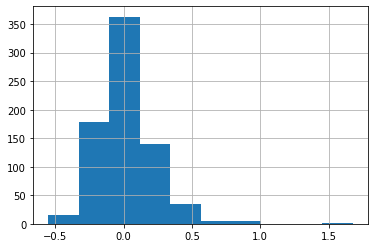

In [55]:
print('GPCP_g')
data.GPCP_g.hist()


year


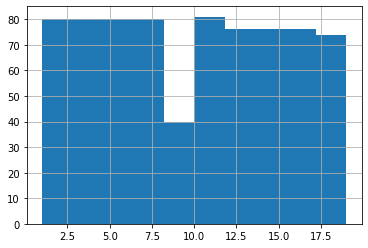

In [54]:
plt.figure()
print('year')
data.year.hist()

month


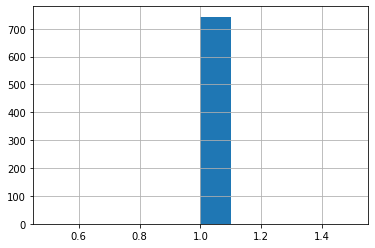

In [53]:
plt.figure()
print('month')
data.month.hist()

day


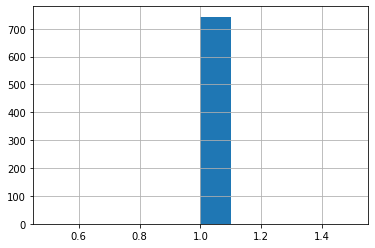

In [52]:
plt.figure()
print('day')
data.day.hist()

any_prio


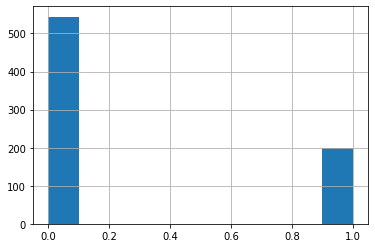

In [51]:
plt.figure()
print('any_prio')
data.any_prio.hist()

war_prio


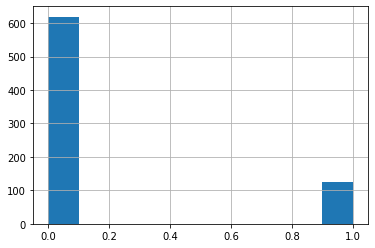

In [50]:
plt.figure()
print('war_prio')
data.war_prio.hist()

ccode


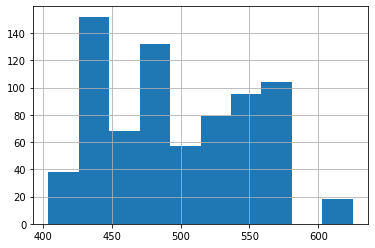

In [49]:
plt.figure()
print('ccode')
data.ccode.hist()

GPCP_g_l


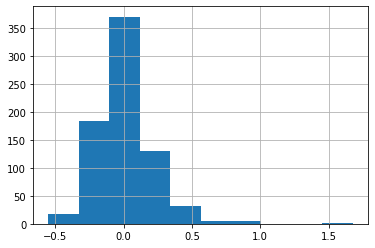

In [41]:
plt.figure()
print('GPCP_g_l')
data.GPCP_g_l.hist()

y_0


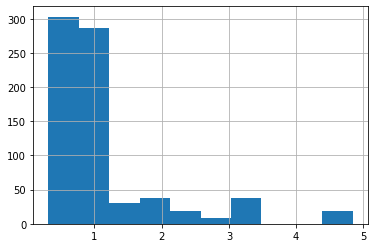

In [42]:
plt.figure()
print('y_0')
data.y_0.hist()

polity2l


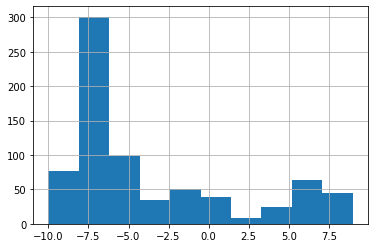

In [43]:
plt.figure()
print('polity2l')
data.polity2l.hist()

ethfrac


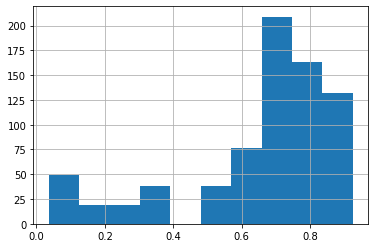

In [44]:
plt.figure()
print('ethfrac')
data.ethfrac.hist()

relfrac


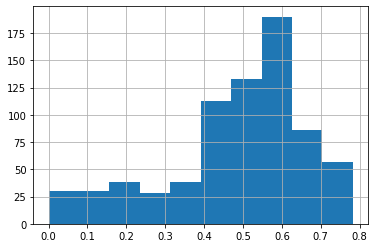

In [45]:
plt.figure()
print('relfrac')
data.relfrac.hist()

Oil


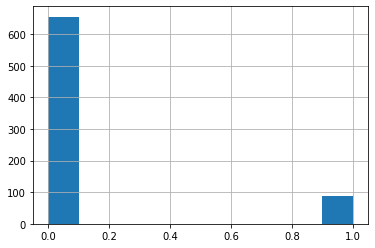

In [46]:
plt.figure()
print('Oil')
data.Oil.hist()

lpopl1


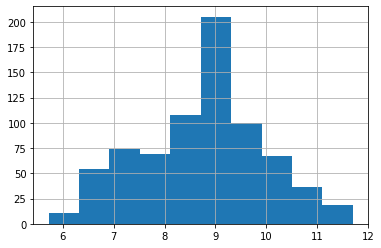

In [47]:
plt.figure()
print('lpopl1')
data.lpopl1.hist()

lmtnest


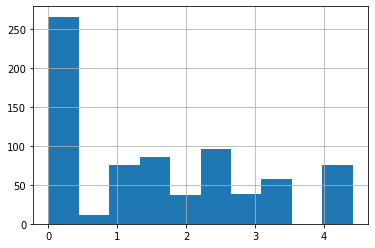

In [48]:
plt.figure()
print('lmtnest')
data.lmtnest.hist()

## final data

In [ ]:
## Z -->  X --> Y
##       / \
## Z_-->Z_

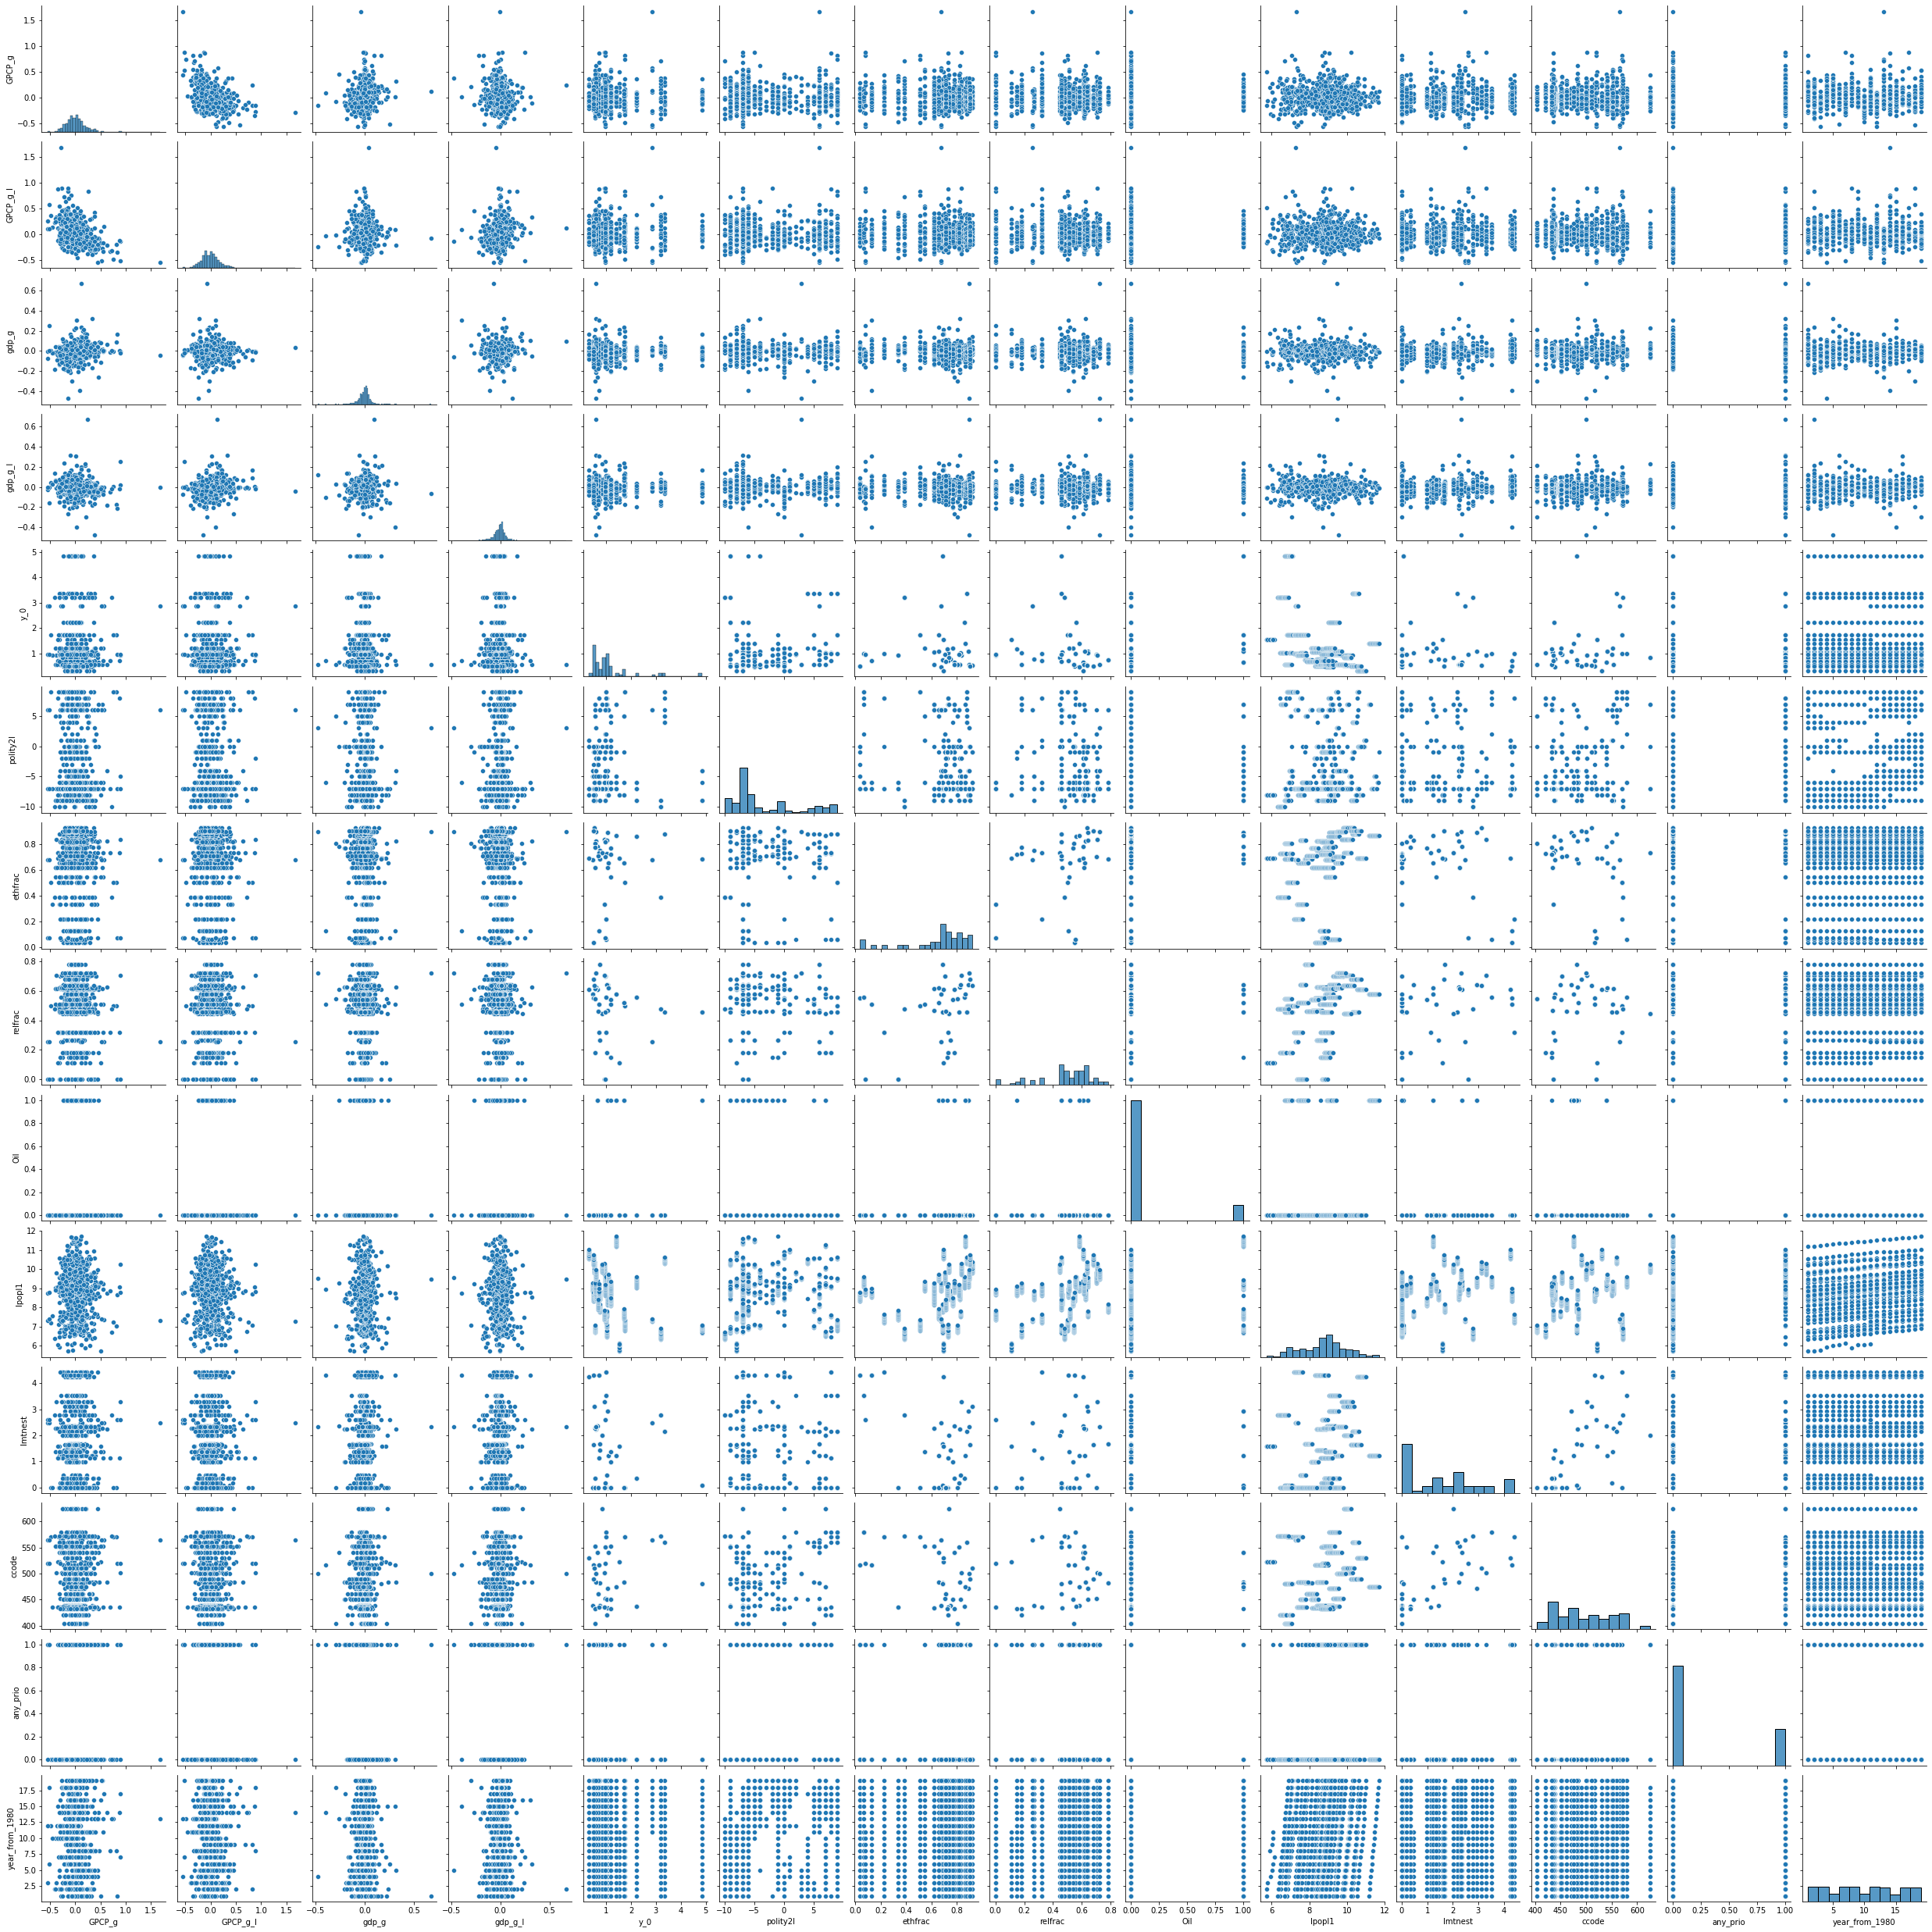

In [3]:

import seaborn as sns
sns.pairplot(data_inp_wo_war_prio)

In [3]:
from scipy.stats import pearsonr



In [4]:
data_inp_wo_war_prio.head(20)

,GPCP_g,GPCP_g_l,gdp_g,gdp_g_l,y_0,polity2l,ethfrac,relfrac,Oil,lpopl1,lmtnest,ccode,any_prio,year_from_1980
0,-0.079653,-0.107587,-0.037037,0.019637,0.662,-7.0,0.783282,0.6122,1.0,8.933400,2.370244,540.0,1.0,1
1,0.155680,-0.079653,0.044615,-0.037037,0.662,-7.0,0.783282,0.6122,1.0,8.959697,2.370244,540.0,1.0,2
2,-0.034482,0.155680,-0.008837,0.044615,0.662,-7.0,0.783282,0.6122,1.0,8.985946,2.370244,540.0,1.0,3
3,0.059925,-0.034482,0.026746,-0.008837,0.662,-7.0,0.783282,0.6122,1.0,9.012134,2.370244,540.0,1.0,4
4,-0.018277,0.059925,0.028944,0.026746,0.662,-7.0,0.783282,0.6122,1.0,9.035987,2.370244,540.0,1.0,5
5,0.216019,-0.018277,-0.002813,0.028944,0.662,-7.0,0.783282,0.6122,1.0,9.060099,2.370244,540.0,1.0,6
6,-0.103502,0.216019,0.011284,-0.002813,0.662,-7.0,0.783282,0.6122,1.0,9.087155,2.370244,540.0,1.0,7
7,0.147912,-0.103502,0.022315,0.011284,0.662,-7.0,0.783282,0.6122,1.0,9.114270,2.370244,540.0,1.0,8
8,-0.116582,0.147912,-0.043656,0.022315,0.662,-7.0,0.783282,0.6122,1.0,9.141418,2.370244,540.0,1.0,9
9,0.052566,-0.116582,-0.033511,-0.043656,0.662,-7.0,0.783282,0.6122,1.0,9.168476,2.370244,540.0,1.0,10


In [5]:
Oil = pd.get_dummies(data_inp_wo_war_prio.Oil, prefix='Oil')
polity2l = pd.get_dummies(data_inp_wo_war_prio.polity2l, prefix='polity2l')
ccode = pd.get_dummies(data_inp_wo_war_prio.ccode, prefix='ccode')
year_from_1980 = pd.get_dummies(data_inp_wo_war_prio.year_from_1980, prefix='year_from_1980')
data_inp = data_inp_wo_war_prio.drop(columns=['Oil', 'polity2l', 'ccode', 'year_from_1980'])
data_inp = pd.concat([data_inp, Oil, polity2l, ccode, year_from_1980], axis=1)
# print(Oils.head())
# data = pd.concat([data_inp_wo_war_prio, Oils], axis=1)
data_inp.head()

cts_columns = ['GPCP_g', 'GPCP_g_l', 'gdp_g', 'gdp_g_l', 'y_0', 'ethfrac', 'relfrac', 'lpopl1', 'lmtnest']
for col in cts_columns:
    data_inp[col] = (data_inp[col] - data_inp[col].mean())/data_inp[col].std()


In [7]:
data_inp.columns

Index(['GPCP_g', 'GPCP_g_l', 'gdp_g', 'gdp_g_l', 'y_0', 'ethfrac', 'relfrac',
       'lpopl1', 'lmtnest', 'any_prio', 'Oil_0.0', 'Oil_1.0', 'polity2l_-10.0',
       'polity2l_-9.0', 'polity2l_-8.0', 'polity2l_-7.0', 'polity2l_-6.0',
       'polity2l_-5.0', 'polity2l_-4.0', 'polity2l_-3.0', 'polity2l_-2.0',
       'polity2l_-1.0', 'polity2l_0.0', 'polity2l_1.0', 'polity2l_2.0',
       'polity2l_3.0', 'polity2l_4.0', 'polity2l_5.0', 'polity2l_6.0',
       'polity2l_7.0', 'polity2l_8.0', 'polity2l_9.0', 'ccode_404.0',
       'ccode_420.0', 'ccode_432.0', 'ccode_433.0', 'ccode_434.0',
       'ccode_435.0', 'ccode_436.0', 'ccode_437.0', 'ccode_438.0',
       'ccode_439.0', 'ccode_450.0', 'ccode_451.0', 'ccode_452.0',
       'ccode_461.0', 'ccode_471.0', 'ccode_475.0', 'ccode_481.0',
       'ccode_482.0', 'ccode_483.0', 'ccode_484.0', 'ccode_490.0',
       'ccode_500.0', 'ccode_501.0', 'ccode_510.0', 'ccode_516.0',
       'ccode_517.0', 'ccode_520.0', 'ccode_522.0', 'ccode_530.0',
       'cc

In [8]:
data_inp_transformed.GPCP_g = data_inp_wo_war_prio.GPCP_g

In [9]:
data_inp_transformed.GPCP_g

0     -0.079653
1      0.155680
2     -0.034482
3      0.059925
4     -0.018277
         ...   
738    0.061179
739    0.513642
740    0.044380
741   -0.181482
742    0.094420
Name: GPCP_g, Length: 743, dtype: float64

## testing statistical independence

In [81]:
var = 'gdp_g'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



gdp_g
---gdp correlation---
(0.03111133422650594, 0.3971006163704165)
(0.9999999999999999, 0.0)
---war correlation---
(-0.04973220036895102, 0.1756862164677384)
---iv correlation---
(0.12353176243319126, 0.0007395106386859553)
(0.032514439490158774, 0.3761451699872394)


In [80]:
var = 'gdp_g_l'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



gdp_g_l
---gdp correlation---
(0.9999999999999999, 0.0)
(0.03111133422650594, 0.3971006163704165)
---war correlation---
(-0.013406396753498183, 0.7152360372972839)
---iv correlation---
(-0.06552662173614064, 0.07425517417073803)
(0.12633993509140976, 0.0005568198405934471)


In [79]:


var = 'y_0'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



y_0
---gdp correlation---
(-0.009500430039020555, 0.7959957399906077)
(-0.02294741490004732, 0.5322793519440536)
---war correlation---
(-0.1509356173584063, 3.6123814028038505e-05)
---iv correlation---
(0.014212902156994745, 0.6989169252514227)
(0.027319168276668686, 0.45714778468680467)


In [78]:

var = 'polity2l'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



polity2l
---gdp correlation---
(0.042316596001318305, 0.2493042693911624)
(0.03265163333834209, 0.3741333869368141)
---war correlation---
(-0.006537617891871683, 0.8587980339814603)
---iv correlation---
(0.035651030566457145, 0.3318226921957457)
(0.03121825514581036, 0.395479432799202)


In [77]:

var = 'ethfrac'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



ethfrac
---gdp correlation---
(-0.013498655914171705, 0.7133624723318027)
(-0.014020845461783763, 0.7027908277020796)
---war correlation---
(0.059762552392307204, 0.10358393787086612)
---iv correlation---
(-0.02245557183546271, 0.5411061963343827)
(-0.028593672962578812, 0.4364193144239599)


In [76]:


var = 'relfrac'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



relfrac
---gdp correlation---
(-0.005234405115188892, 0.8867322299945521)
(-0.008576863975081816, 0.8154515476875619)
---war correlation---
(0.08797626173770522, 0.01645455287286625)
---iv correlation---
(-0.04358180154804933, 0.23541797293769665)
(-0.03964171568032904, 0.28051648021048065)


In [75]:


var = 'Oil'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



Oil
---gdp correlation---
(-0.011817550796799315, 0.7477618122462131)
(-0.042472371647469365, 0.24756435422962936)
---war correlation---
(-0.005354912678235704, 0.8841427168450527)
---iv correlation---
(-0.006532380935021588, 0.8589099593021149)
(-0.012137347642530162, 0.7411768578508863)


In [74]:


var = 'lpopl1'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



lpopl1
---gdp correlation---
(-0.007789391926331426, 0.8321310765393795)
(-0.0031694233738955874, 0.9312700802369042)
---war correlation---
(0.2846952035417242, 2.5439961841528133e-15)
---iv correlation---
(-0.022453035123167518, 0.5411519098106372)
(-0.027090862662746452, 0.46091836062659797)


In [69]:


var = 'ccode'
print(var)

print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



ccode
---gdp correlation---
(0.040732836483820464, 0.2674786803150493)
(0.03405346219005292, 0.3539596696055214)
---war correlation---
(0.18386689444362617, 4.4998797041419304e-07)
---iv correlation---
(0.011872917156464593, 0.7466204296002532)
(0.024058784675094928, 0.5126057899188787)


In [70]:


var = 'year_from_1980'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



year_from_1980
---gdp correlation---
(0.055254101986999, 0.13239309426488127)
(0.05619620566148843, 0.1259107886260391)
---war correlation---
(0.05306236473624553, 0.148469633902887)
---iv correlation---
(0.02034705372358392, 0.5797540217008681)
(0.002816858746062108, 0.938899685566753)


In [72]:
var = 'lmtnest'
print(var)
print('---gdp correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g_l.values))

print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.gdp_g.values))

print('---war correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, data_inp_wo_war_prio.any_prio.values))

print('---iv correlation---')
print(pearsonr(data_inp_wo_war_prio[var].values, z1))

print(pearsonr(data_inp_wo_war_prio[var].values, z2))



lmtnest
---gdp correlation---
(0.009360004379356836, 0.7989461178274047)
(0.011307400816639075, 0.7583042812371336)
---war correlation---
(0.23463179082073138, 9.453730553788345e-11)
---iv correlation---
(0.0010032959216140559, 0.9782189983391234)
(0.0047112731041745876, 0.8979871384787205)


## Data

confound: ccode, year_from_1980

on y: y_0, ethfrac, relfrac, lpopl1, lmtnest

on x: polity2l, Oil

on neither: 

In [6]:
Z1 = data_inp.GPCP_g.values[:, np.newaxis]
Z2 = data_inp.GPCP_g_l.values[:, np.newaxis]
Z = np.concatenate([Z1, Z2], axis=-1)
M = data_inp.gdp_g.values[:, np.newaxis]
N = data_inp.gdp_g_l.values[:, np.newaxis]
Y = data_inp.any_prio.values[:, np.newaxis]
Y_covariates = np.concatenate([data_inp.y_0.values[:, np.newaxis],
                    data_inp.ethfrac.values[:, np.newaxis],
                    data_inp.relfrac.values[:, np.newaxis],
                    data_inp.lpopl1.values[:, np.newaxis],
                    data_inp.lmtnest.values[:, np.newaxis]], axis=-1)

Uccode = np.concatenate([data_inp[ccode].values[:, np.newaxis] for ccode in ['ccode_404.0',
       'ccode_420.0', 'ccode_432.0', 'ccode_433.0', 'ccode_434.0',
       'ccode_435.0', 'ccode_436.0', 'ccode_437.0', 'ccode_438.0',
       'ccode_439.0', 'ccode_450.0', 'ccode_451.0', 'ccode_452.0',
       'ccode_461.0', 'ccode_471.0', 'ccode_475.0', 'ccode_481.0',
       'ccode_482.0', 'ccode_483.0', 'ccode_484.0', 'ccode_490.0',
       'ccode_500.0', 'ccode_501.0', 'ccode_510.0', 'ccode_516.0',
       'ccode_517.0', 'ccode_520.0', 'ccode_522.0', 'ccode_530.0',
       'ccode_540.0', 'ccode_541.0', 'ccode_551.0', 'ccode_552.0',
       'ccode_553.0', 'ccode_560.0', 'ccode_565.0', 'ccode_570.0',
       'ccode_571.0', 'ccode_572.0', 'ccode_580.0', 'ccode_625.0']], axis=-1)

Uyear = np.concatenate([data_inp[year].values[:, np.newaxis] for year in ['year_from_1980_1', 'year_from_1980_2', 'year_from_1980_3',
       'year_from_1980_4', 'year_from_1980_5', 'year_from_1980_6',
       'year_from_1980_7', 'year_from_1980_8', 'year_from_1980_9',
       'year_from_1980_10', 'year_from_1980_11', 'year_from_1980_12',
       'year_from_1980_13', 'year_from_1980_14', 'year_from_1980_15',
       'year_from_1980_16', 'year_from_1980_17', 'year_from_1980_18',
       'year_from_1980_19']], axis=-1)

U = np.float64(np.concatenate([Uccode, Uyear], axis=-1))


In [7]:
train_data = dotdict({'M': torch.tensor(M),
                      'N': torch.tensor(N),
                      'Z': torch.tensor(Z),
                      'Y_covariate': torch.tensor(Y_covariates), 
                      'U': torch.tensor(U),
                      'Y': torch.tensor(Y)})


In [47]:
train_data.U.shape

torch.Size([743, 60])

## Generate X - latent variable model

p(x|z) = mixtureDensityModel(mu(z), std(z))

p(m|x) = mixtureDensityModel()

p(n|x) = mixtureDensityModel()

In [9]:
m = torch.nn.Softmax(dim=1)
inp = torch.randn(2, 3)
output = m(inp)
print(inp)
print(output)

tensor([[ 1.0239,  0.8670,  2.6494],
        [-1.5726, -0.3136,  0.5732]])
tensor([[0.1442, 0.1232, 0.7326],
        [0.0765, 0.2695, 0.6540]])


In [81]:
##             U 
##           /  \    
##          /    \    
##   Z --> X --> Y <-- Y_covariate
##        / \
##       /   \
##      M    N
##
## 
##
## E[Y|Z] = E[f(X)|Z] 
## f(X) = a + b X + c X^2 
## Y|X,U  = f(X) + g(U) + eps
## E[f(X)|Z]= a + b E[X|Z] + cE[X^2|Z]
## X|Z,U
## (Y - E[f(X)|Z])^2
## Y = f(X, W) + epsilon
## E[Y|Z] = E[f(X, W)|Z] = int_{x,w} f(x,w) p(x|w,z)p(w|z)
## 

## p({x}|{z}) = prod_i (p(x_i|z_i))
## 
## covariates: y_0, polity2l, ethfrac, 
##             relfrac, Oil, lpopl1, 
##             lmtnest, ccode, year
## X: true GDP
## M: gdp_g
## N: gdp_g_l
## Z: GPCP_g, GPCP_g_l (railfall)
## Y: any_prio, war_prio



num_u = 60
num_y_covar = 5

# likelihood models
class Encoder1(torch.nn.Module):
    # q({x}|{m},{n},{z}, {covar}, {y}) = gaussian(q0 + q1*{m} + q2*{n} + q3*{z}, 
    #                       exp(qq0 + qq1*{m} + qq2*{n} + qq3*{z})^2)
    # input dim = dim_m + dim_n + dim_z + dim_covar + dim_u + dim_y = 70
    # H[q] = -E_q[log(q)] = log(prod(sigma)*(2*pi*e)**(B*0.5))
    def __init__(self, data):
        super().__init__()
        input_dim = 70
        self.q_nonlinear = nn.Sequential(nn.Linear(input_dim, 26), nn.ReLU())
#         self.q_mean_fc = nn.Linear(3, 1)
#         self.q_logscale_fc = nn.Linear(3, 1)
        self.q_mean_fc = nn.Linear(26, 1)
        self.q_logscale_fc = nn.Linear(26, 1)
        self.data = data
        
    def forward(self, idx):
        
        
        q_mean, q_scale, H_q = self.forward_(self.data.M[idx], self.data.N[idx], self.data.Z[idx], 
                              self.data.U[idx], self.data.Y[idx], self.data.Y_covariate[idx])
        
        return q_mean, q_scale, H_q
    
    def forward_(self, m, n, z, u, y, ycov):
        B = m.shape[0]
        
        mnzuyycov = torch.cat([m, n, z, u, y, ycov], axis=1)
        
        q_feature = self.q_nonlinear(mnzuyycov)
        q_mean = self.q_mean_fc(q_feature)
#         q_mean = self.q_mean_fc(mnz.double())
        q_logscale = self.q_logscale_fc(q_feature)
#         q_logscale = self.q_logscale_fc(mnz)
        q_scale = torch.exp(q_logscale)
        
        H_q = torch.log(torch.prod(q_scale)*(2*torch.pi*torch.e)**(B*0.5))
        
        return q_mean, q_scale, H_q
        

class Encoder2(torch.nn.Module):
    # q({x}|{m},{n},{z}, {u}) = gaussian(q0 + q1*{m} + q2*{n} + q3*{z}, 
    #                       exp(qq0 + qq1*{m} + qq2*{n} + qq3*{z})^2)
    # input dim = dim_m + dim_n + dim_z + dim_u = 64
    # H[q] = -E_q[log(q)] = log(prod(sigma)*(2*pi*e)**(B*0.5))
    def __init__(self, data):
        super().__init__()
        input_dim = 64
        self.q_nonlinear = nn.Sequential(nn.Linear(input_dim, 26), nn.ReLU())
#         self.q_mean_fc = nn.Linear(3, 1)
#         self.q_logscale_fc = nn.Linear(3, 1)
        self.q_mean_fc = nn.Linear(26, 1)
        self.q_logscale_fc = nn.Linear(26, 1)
        self.data = data
        
    def forward(self, idx):
        
        q_mean, q_scale, H_q = self.forward_(self.data.M[idx], self.data.N[idx], self.data.Z[idx], 
                              self.data.U[idx])
        
        return q_mean, q_scale, H_q
    
    def forward_(self, m, n, z, u):
        B = m.shape[0]
        
        mnzu = torch.cat([m, n, z, u], axis=1)
        
        q_feature = self.q_nonlinear(mnzu)
        q_mean = self.q_mean_fc(q_feature)
#         q_mean = self.q_mean_fc(mnz.double())
        q_logscale = self.q_logscale_fc(q_feature)
#         q_logscale = self.q_logscale_fc(mnz)
        q_scale = torch.exp(q_logscale)
        
        H_q = torch.log(torch.prod(q_scale)*(2*torch.pi*torch.e)**(B*0.5))
        
        return q_mean, q_scale, H_q
    

class Encoder3(torch.nn.Module):
    # q({x}|{m},{n},{z}) = gaussian(q0 + q1*{m} + q2*{n} + q3*{z}, 
    #                       exp(qq0 + qq1*{m} + qq2*{n} + qq3*{z})^2)
    # input dim = dim_m + dim_n + dim_z + dim_u = 4
    # H[q] = -E_q[log(q)] = log(prod(sigma)*(2*pi*e)**(B*0.5))
    def __init__(self, data):
        super().__init__()
        input_dim = 4
        self.q_nonlinear = nn.Sequential(nn.Linear(input_dim, 26), nn.ReLU())
#         self.q_mean_fc = nn.Linear(3, 1)
#         self.q_logscale_fc = nn.Linear(3, 1)
        self.q_mean_fc = nn.Linear(26, 1)
        self.q_logscale_fc = nn.Linear(26, 1)
        self.data = data
        
    def forward(self, idx):
        
        q_mean, q_scale, H_q = self.forward_(self.data.M[idx], self.data.N[idx], self.data.Z[idx])
        
        return q_mean, q_scale, H_q
    
    def forward_(self, m, n, z):
        B = m.shape[0]
        
        mnzu = torch.cat([m, n, z], axis=1)
        
        q_feature = self.q_nonlinear(mnzu)
        q_mean = self.q_mean_fc(q_feature)
#         q_mean = self.q_mean_fc(mnz.double())
        q_logscale = self.q_logscale_fc(q_feature)
#         q_logscale = self.q_logscale_fc(mnz)
        q_scale = torch.exp(q_logscale)
        
        H_q = torch.log(torch.prod(q_scale)*(2*torch.pi*torch.e)**(B*0.5))
        
        return q_mean, q_scale, H_q
    
        

class MDecoder(torch.nn.Module):
    # p(m|x) = gaussian(x, exp(mm0 + mm1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.m_logscale_fc = nn.Linear(1,1)
#         self.mm1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
#         self.mm0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pmx_mean = x
        pmx_logscale = self.m_logscale_fc(x.double())
#         pmx_logscale = self.mm0 + x.matmul(self.mm1)
        pmx_scale = torch.exp(pmx_logscale)
        
        return pmx_mean, pmx_scale

class NDecoder(torch.nn.Module):
    # p(n|x) = gaussian(x, exp(nn0 + nn1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.n_logscale_fc = nn.Linear(1,1)
#         self.nn1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
#         self.nn0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pnx_mean = x
        pnx_logscale = self.n_logscale_fc(x.double())
#         pnx_logscale = self.nn0 + x.matmul(self.nn1)
        pnx_scale = torch.exp(pnx_logscale)
        
        return pnx_mean, pnx_scale
    

class XModel(torch.nn.Module):
    # p(x|z, u) = gaussian(f(Z, U), exp(zz0 + zz1 * x)^2)
    # input dim = dim_z + dim_u = 62
    def __init__(self, data):
        super().__init__()
        self.x_feature = nn.Sequential(nn.Linear(62, 10), nn.ReLU())
        self.x_mean_fc = nn.Linear(10,1)
        self.x_logscale_fc = nn.Linear(10,1)
#         self.zz1 = torch.nn.Parameter(torch.tensor([[3.]]).double())
#         self.zz0 = torch.nn.Parameter(torch.log(torch.tensor([[1.]])).double())
        self.data = data
        
    def forward(self, idx):
        z = self.data.Z[idx]
        u = self.data.U[idx]
        pxzu_mean, pxzu_scale = self.forward_(z, u)
        
        return pxzu_mean, pxzu_scale
    
    def forward_(self, z, u):
        zu = torch.cat([z,u], axis=-1)
        zu_feature = self.x_feature(zu)
        pxzu_mean = self.x_mean_fc(zu_feature)
        pxzu_logscale = self.x_logscale_fc(zu_feature)
        pxzu_scale = torch.exp(pxzu_logscale)

        return pxzu_mean, pxzu_scale
    
    
class XModel3(torch.nn.Module):
    # p(x|z, u) = gaussian(f(Z, U), exp(zz0 + zz1 * x)^2)
    # input dim = dim_z = 2
    def __init__(self, data):
        super().__init__()
        self.x_feature = nn.Sequential(nn.Linear(2, 10), nn.ReLU())
        self.x_mean_fc = nn.Linear(10,1)
        self.x_logscale_fc = nn.Linear(10,1)
#         self.zz1 = torch.nn.Parameter(torch.tensor([[3.]]).double())
#         self.zz0 = torch.nn.Parameter(torch.log(torch.tensor([[1.]])).double())
        self.data = data
        
    def forward(self, idx):
        z = self.data.Z[idx]
        pxzu_mean, pxzu_scale = self.forward_(z)
        
        return pxzu_mean, pxzu_scale
    
    def forward_(self, z):
        z_feature = self.x_feature(z)
        pxzu_mean = self.x_mean_fc(z_feature)
        pxzu_logscale = self.x_logscale_fc(z_feature)
        pxzu_scale = torch.exp(pxzu_logscale)

        return pxzu_mean, pxzu_scale
    

class YModel(torch.nn.Module):
    # Y = f(X) + g(U) + h(Y_covar) + eps
    # p(y|x, u, y_covar) = gaussian(f(x) + g(u) + h(Y_covar), eps)
    # input dim = dim_x + dim_u + dim_ycovar = 1 + 2 + 5 = 8
    
    def __init__(self, data):
        super().__init__()
        self.fx = nn.Sequential(nn.Linear(1, 5), nn.ReLU(), nn.Linear(5, 1))
        
        self.gu = nn.Sequential(nn.Linear(60, 5), nn.ReLU(), nn.Linear(5, 1))
        
        self.hy_covar = nn.Sequential(nn.Linear(5, 10), nn.ReLU(), nn.Linear(10, 1))
        
        self.y_noise_logscale = nn.Linear(66, 1)
        
        self.data = data
    
    def forward(self, x, idx):
        
        u = self.data.U[idx]
        y_covar = self.data.Y_covariate[idx]
        
        pyxuycovar_mean, pyxuycovar_scale = self.forward_(x, u, y_covar)
        
        return pyxuycovar_mean, pyxuycovar_scale
    
    def forward_(self, x, u, y_covar):
        fx = self.fx(x)
        gu = self.gu(u)
        hy_covar = self.hy_covar(y_covar)

        pyxuycovar_mean = fx + gu + hy_covar
        
        pyxuycovar_scale = torch.exp(self.y_noise_logscale(torch.cat([x, u, y_covar], axis=-1)))
        
        return pyxuycovar_mean, pyxuycovar_scale
        
    
# class ResponseModel(torch.nn.Module):
#     # y = f(x) + noise
#     def __init__(self):
#         super().__init__()
#         self.response_net = nn.Sequential(nn.Linear(1+num_covar, 3), 
#                                           nn.ReLU(), 
#                                           nn.Linear(3, 3),
#                                           nn.ReLU(),
#                                           nn.Linear(3, 2))
        
# #         self.response_net = nn.Sequential(nn.Linear(1, 1))
#     def forward(self, response_inp):
#         softmax = torch.nn.Softmax(dim=1)
#         probs = softmax(self.response_net(response_inp))
#         return probs
        

class LVM(torch.nn.Module):
    def __init__(self, data, sample_size_from_pxz):
        super().__init__()
        self.xmodel = XModel(data)
        self.ndecoder = NDecoder(data)
        self.mdecoder = MDecoder(data)
        self.encoder = Encoder1(data)
        self.ymodel = YModel(data)
        self.data = data
        self.sample_size_from_pxz = sample_size_from_pxz
    
    
    def stage_1_loss(self, idx):
        ### Free energy = E_q[log(p({m},{n},{x}|{z})) - log(q)] 
        ###             = E_q[log(p({m},{n},{x}|{z}))] + H_q({m},{n},{z})
        ###             = E_q[sum_i{log(p(m_i, n_i, x_i|z_i))}] + H_q({m}, {n}, {z})
        ###             = E_q[sum_i{log(p(m_i|x_i))} + sum_i{log(p(n_i|x_i))} + sum_i{log(p(x_i|z_i))}]
        ###               + H_q({m},{n},{z})
        ###             = sum_i{E_q[log(p(m_i|x_i))]} 
        ###               + sum_i{E_q[log(p(n_i|x_i))]} 
        ###               + sum_i{E_q[log(p(x_i|z_i))]} 
        ###               + H_q({m},{n},{z})
        ### ELBO = - sum_i{E_q[log(p(m_i|x_i))]} 
        ###        - sum_i{E_q[log(p(n_i|x_i))]} 
        ###        - sum_i{E_q[log(p(x_i|z_i))]} 
        ###        - H_q({m},{n},{z})
    
        q_mean, q_scale, H_q = self.encoder(idx)
        q_dist = torch.distributions.Normal(q_mean, q_scale)
        x_samples_from_q = q_dist.rsample()

        pmx_mean, pmx_scale = self.mdecoder(x_samples_from_q)
        pmx_dist = torch.distributions.Normal(pmx_mean, pmx_scale)
        sum_pmx = torch.sum(pmx_dist.log_prob(data.M[idx]))

        pnx_mean, pnx_scale = self.ndecoder(x_samples_from_q)
        pnx_dist = torch.distributions.Normal(pnx_mean, pnx_scale)
        sum_pnx = torch.sum(pnx_dist.log_prob(data.N[idx]))

        pxzu_mean, pxzu_scale = self.xmodel(idx)
        pxzu_dist = torch.distributions.Normal(pxzu_mean, pxzu_scale)
        sum_pxzu = torch.sum(pxzu_dist.log_prob(x_samples_from_q))
        
#         loss = -sum_pmx - sum_pnx - sum_pxzu - H_q
        
        pyxu_mean, pyxu_scale = self.ymodel(x_samples_from_q, idx)
        pyxu_dist = torch.distributions.Normal(pyxu_mean, pyxu_scale)
        sum_pyxu = torch.sum(pyxu_dist.log_prob(data.Y[idx]))

        loss = -sum_pmx - sum_pnx - sum_pxzu - sum_pyxu - H_q
        
        return loss
    
#     @staticmethod
#     def cross_entropy_loss(pred, true):
        
#         return loss
        
    
#     def stage_2_loss(self, idx):
#         # {Z, Y}
#         # E[Y|Z] = E[f(X)|Z] vs E[Y|X] = f(X)

#         with torch.no_grad():
            
#             pxz_mean, pxz_scale = self.ivm(idx)
#             pxz_dist = torch.distributions.Normal(pxz_mean, pxz_scale)
            
#             x_samples_from_z = pxz_dist.rsample(sample_shape=(self.sample_size_from_pxz,))
            
#             dim_x = x_samples_from_z.shape[-1]
            

            
#         response_inp = torch.cat([x_samples_from_z.reshape(-1, dim_x), 
#                                   self.data.Y_covariate[idx].repeat((self.sample_size_from_pxz, 1)).reshape(-1, self.data.Y_covariate.shape[-1])], axis=-1)
        
#         preds_1 = torch.mean(self.response(response_inp[:, :1]).reshape(self.sample_size_from_pxz, -1), axis=0).reshape(-1,1)
#         preds_2 = torch.ones(preds_1.shape) - preds_1
#         probs = torch.cat([preds_1, preds_2], dim=1)
        
#         cross_entropy_loss = nn.CrossEntropyLoss()
        
#         loss = cross_entropy_loss(probs, target)
        
# #         breakpoint()
        
#         return loss
    

In [18]:
torch.randn(3, 5, requires_grad=True)

tensor([[-0.8882,  0.6522, -0.9412, -1.5287,  1.7077],
        [-0.6134,  0.1075,  0.3281,  0.9897, -0.0499],
        [-0.0442, -2.4368, -0.3342,  1.3321, -0.8019]], requires_grad=True)

## Training function

In [82]:
def split_into_batches(train_size, batch_size):
    batches_idxes = []
    idxes = np.arange(train_size)
    np.random.shuffle(idxes)
    batch_i = 0
    while True:
        batches_idxes.append(torch.tensor(idxes[batch_i * batch_size: (batch_i + 1) * batch_size]))
        batch_i += 1
        if batch_i * batch_size >= train_size:
            break
    return batches_idxes

def train1(lvm, data, batch_size):
    lvm.train()
    lvm.double()
    optimizer = optim.Adam(lvm.parameters(), lr=1e-3)
    losses = []
    step = 0
    for ep in range(1500):
        running_loss = 0.0
        batches_idx = split_into_batches(train_size=data.Z.shape[0], batch_size=batch_size)
        for i, batch_idx in enumerate(batches_idx):
            loss = lvm.stage_1_loss(batch_idx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 1 == 0:
                print('[epoch %d, batch %5d] loss: %.5f' % (
                ep + 1, i + 1, running_loss / 1))
                # breakpoint()
                running_loss = 0.0
                
            losses.append(loss.item())
            
            step += 1
            
    return lvm

def train2(lvm, data, batch_size):
    lvm.eval()
    lvm.response.train()
    lvm.double()
    optimizer = optim.Adam(lvm.response.parameters(), lr=1e-3)
    losses = []
    step = 0
    for ep in range(500):
        running_loss = 0.0
        batches_idx = split_into_batches(train_size=data.Z.shape[0], batch_size=batch_size)
        for i, batch_idx in enumerate(batches_idx):
            loss = lvm.stage_2_loss(batch_idx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 1 == 0:
                print('[epoch %d, batch %5d] loss: %.5f' % (
                ep + 1, i + 1, running_loss / 1))
                running_loss = 0.0
            
            losses.append(loss.item())
            
            step += 1
    return lvm
                
    


## main

In [83]:
sample_size_from_pxz = 100
data = train_data
lvm = LVM(data, sample_size_from_pxz=sample_size_from_pxz)
# print('response_net_param: ', lvm.response.response_net[0].weight)
print('iv model param: ', lvm.xmodel.x_logscale_fc.weight)



iv model param:  Parameter containing:
tensor([[ 0.1320, -0.0818, -0.2325, -0.2294, -0.2256,  0.2154, -0.0126, -0.3016,
         -0.0008,  0.0957]], requires_grad=True)


In [84]:
lvm = train1(lvm, data, batch_size=64)


[epoch 1, batch     1] loss: 541.09336
[epoch 1, batch     2] loss: 553.50031
[epoch 1, batch     3] loss: 489.25934
[epoch 1, batch     4] loss: 765.32430
[epoch 1, batch     5] loss: 308.85627
[epoch 1, batch     6] loss: 623.47058
[epoch 1, batch     7] loss: 514.56156
[epoch 1, batch     8] loss: 733.54788
[epoch 1, batch     9] loss: 772.48270
[epoch 1, batch    10] loss: 601.48564
[epoch 1, batch    11] loss: 495.25258
[epoch 1, batch    12] loss: 258.11330
[epoch 2, batch     1] loss: 490.05300
[epoch 2, batch     2] loss: 537.26256
[epoch 2, batch     3] loss: 482.79396
[epoch 2, batch     4] loss: 321.51087
[epoch 2, batch     5] loss: 467.91390
[epoch 2, batch     6] loss: 332.85194
[epoch 2, batch     7] loss: 511.81919
[epoch 2, batch     8] loss: 280.92000
[epoch 2, batch     9] loss: 481.80003
[epoch 2, batch    10] loss: 531.15532
[epoch 2, batch    11] loss: 480.06696
[epoch 2, batch    12] loss: 329.02587
[epoch 3, batch     1] loss: 384.12650
[epoch 3, batch     2] lo

[epoch 19, batch     8] loss: 211.28214
[epoch 19, batch     9] loss: 330.21684
[epoch 19, batch    10] loss: 233.98950
[epoch 19, batch    11] loss: 242.14872
[epoch 19, batch    12] loss: 160.18441
[epoch 20, batch     1] loss: 238.88979
[epoch 20, batch     2] loss: 211.69990
[epoch 20, batch     3] loss: 214.69339
[epoch 20, batch     4] loss: 229.94691
[epoch 20, batch     5] loss: 202.23215
[epoch 20, batch     6] loss: 231.11214
[epoch 20, batch     7] loss: 213.10861
[epoch 20, batch     8] loss: 241.44366
[epoch 20, batch     9] loss: 215.65914
[epoch 20, batch    10] loss: 328.26142
[epoch 20, batch    11] loss: 204.13186
[epoch 20, batch    12] loss: 110.13630
[epoch 21, batch     1] loss: 213.62985
[epoch 21, batch     2] loss: 218.63541
[epoch 21, batch     3] loss: 196.38943
[epoch 21, batch     4] loss: 206.17954
[epoch 21, batch     5] loss: 248.38065
[epoch 21, batch     6] loss: 235.90695
[epoch 21, batch     7] loss: 318.18492
[epoch 21, batch     8] loss: 213.17119


[epoch 39, batch     6] loss: 183.92874
[epoch 39, batch     7] loss: 223.26418
[epoch 39, batch     8] loss: 155.10644
[epoch 39, batch     9] loss: 225.52356
[epoch 39, batch    10] loss: 194.26833
[epoch 39, batch    11] loss: 164.35445
[epoch 39, batch    12] loss: 110.54333
[epoch 40, batch     1] loss: 180.06157
[epoch 40, batch     2] loss: 205.39266
[epoch 40, batch     3] loss: 164.53373
[epoch 40, batch     4] loss: 190.41481
[epoch 40, batch     5] loss: 182.94419
[epoch 40, batch     6] loss: 188.52727
[epoch 40, batch     7] loss: 248.03531
[epoch 40, batch     8] loss: 176.47187
[epoch 40, batch     9] loss: 207.06715
[epoch 40, batch    10] loss: 184.24234
[epoch 40, batch    11] loss: 150.72849
[epoch 40, batch    12] loss: 108.73577
[epoch 41, batch     1] loss: 197.39599
[epoch 41, batch     2] loss: 228.33706
[epoch 41, batch     3] loss: 191.53388
[epoch 41, batch     4] loss: 206.53288
[epoch 41, batch     5] loss: 197.91787
[epoch 41, batch     6] loss: 184.05949


[epoch 59, batch     3] loss: 203.95507
[epoch 59, batch     4] loss: 191.87203
[epoch 59, batch     5] loss: 185.92358
[epoch 59, batch     6] loss: 135.19206
[epoch 59, batch     7] loss: 139.66357
[epoch 59, batch     8] loss: 134.11564
[epoch 59, batch     9] loss: 175.78652
[epoch 59, batch    10] loss: 149.00401
[epoch 59, batch    11] loss: 171.54401
[epoch 59, batch    12] loss: 77.97232
[epoch 60, batch     1] loss: 187.88458
[epoch 60, batch     2] loss: 181.97956
[epoch 60, batch     3] loss: 147.64133
[epoch 60, batch     4] loss: 160.49244
[epoch 60, batch     5] loss: 191.52559
[epoch 60, batch     6] loss: 186.95468
[epoch 60, batch     7] loss: 163.10172
[epoch 60, batch     8] loss: 132.15531
[epoch 60, batch     9] loss: 176.24078
[epoch 60, batch    10] loss: 148.40308
[epoch 60, batch    11] loss: 134.75246
[epoch 60, batch    12] loss: 113.71673
[epoch 61, batch     1] loss: 124.57296
[epoch 61, batch     2] loss: 147.23591
[epoch 61, batch     3] loss: 173.34796
[

[epoch 78, batch     7] loss: 154.68272
[epoch 78, batch     8] loss: 173.06923
[epoch 78, batch     9] loss: 140.76276
[epoch 78, batch    10] loss: 120.59696
[epoch 78, batch    11] loss: 166.95975
[epoch 78, batch    12] loss: 77.79493
[epoch 79, batch     1] loss: 140.40478
[epoch 79, batch     2] loss: 153.03791
[epoch 79, batch     3] loss: 126.06677
[epoch 79, batch     4] loss: 127.17039
[epoch 79, batch     5] loss: 156.27051
[epoch 79, batch     6] loss: 154.09571
[epoch 79, batch     7] loss: 155.46914
[epoch 79, batch     8] loss: 149.44418
[epoch 79, batch     9] loss: 142.76362
[epoch 79, batch    10] loss: 178.99808
[epoch 79, batch    11] loss: 168.52981
[epoch 79, batch    12] loss: 77.03597
[epoch 80, batch     1] loss: 126.21381
[epoch 80, batch     2] loss: 124.16143
[epoch 80, batch     3] loss: 134.60613
[epoch 80, batch     4] loss: 139.76517
[epoch 80, batch     5] loss: 158.69350
[epoch 80, batch     6] loss: 137.71239
[epoch 80, batch     7] loss: 169.23855
[e

[epoch 97, batch    12] loss: 65.06604
[epoch 98, batch     1] loss: 164.99089
[epoch 98, batch     2] loss: 105.51046
[epoch 98, batch     3] loss: 130.17154
[epoch 98, batch     4] loss: 126.48802
[epoch 98, batch     5] loss: 109.50895
[epoch 98, batch     6] loss: 114.06626
[epoch 98, batch     7] loss: 112.35008
[epoch 98, batch     8] loss: 152.64116
[epoch 98, batch     9] loss: 129.99667
[epoch 98, batch    10] loss: 150.49746
[epoch 98, batch    11] loss: 90.46360
[epoch 98, batch    12] loss: 81.36132
[epoch 99, batch     1] loss: 165.89759
[epoch 99, batch     2] loss: 118.25554
[epoch 99, batch     3] loss: 150.73994
[epoch 99, batch     4] loss: 91.39807
[epoch 99, batch     5] loss: 140.59280
[epoch 99, batch     6] loss: 116.37146
[epoch 99, batch     7] loss: 108.22100
[epoch 99, batch     8] loss: 126.36556
[epoch 99, batch     9] loss: 129.22978
[epoch 99, batch    10] loss: 145.24822
[epoch 99, batch    11] loss: 133.41171
[epoch 99, batch    12] loss: 122.16631
[epo

[epoch 117, batch     7] loss: 96.44327
[epoch 117, batch     8] loss: 111.47120
[epoch 117, batch     9] loss: 118.40728
[epoch 117, batch    10] loss: 111.71024
[epoch 117, batch    11] loss: 87.05371
[epoch 117, batch    12] loss: 76.24444
[epoch 118, batch     1] loss: 66.40511
[epoch 118, batch     2] loss: 106.03447
[epoch 118, batch     3] loss: 96.32088
[epoch 118, batch     4] loss: 145.81968
[epoch 118, batch     5] loss: 140.32950
[epoch 118, batch     6] loss: 118.53311
[epoch 118, batch     7] loss: 120.35628
[epoch 118, batch     8] loss: 110.72609
[epoch 118, batch     9] loss: 133.63246
[epoch 118, batch    10] loss: 116.84754
[epoch 118, batch    11] loss: 110.61180
[epoch 118, batch    12] loss: 100.05777
[epoch 119, batch     1] loss: 136.18809
[epoch 119, batch     2] loss: 125.87343
[epoch 119, batch     3] loss: 115.76071
[epoch 119, batch     4] loss: 105.62089
[epoch 119, batch     5] loss: 135.81037
[epoch 119, batch     6] loss: 110.92352
[epoch 119, batch    

[epoch 136, batch     7] loss: 96.22059
[epoch 136, batch     8] loss: 129.35719
[epoch 136, batch     9] loss: 70.31947
[epoch 136, batch    10] loss: 106.87651
[epoch 136, batch    11] loss: 133.04338
[epoch 136, batch    12] loss: 58.67845
[epoch 137, batch     1] loss: 172.34138
[epoch 137, batch     2] loss: 143.48200
[epoch 137, batch     3] loss: 67.66030
[epoch 137, batch     4] loss: 103.43704
[epoch 137, batch     5] loss: 97.75288
[epoch 137, batch     6] loss: 114.60106
[epoch 137, batch     7] loss: 129.88415
[epoch 137, batch     8] loss: 122.43472
[epoch 137, batch     9] loss: 119.37417
[epoch 137, batch    10] loss: 118.51913
[epoch 137, batch    11] loss: 112.77047
[epoch 137, batch    12] loss: 53.44402
[epoch 138, batch     1] loss: 116.53389
[epoch 138, batch     2] loss: 141.64484
[epoch 138, batch     3] loss: 165.52122
[epoch 138, batch     4] loss: 146.31503
[epoch 138, batch     5] loss: 81.40343
[epoch 138, batch     6] loss: 89.64320
[epoch 138, batch     7]

[epoch 155, batch     1] loss: 69.42754
[epoch 155, batch     2] loss: 84.86121
[epoch 155, batch     3] loss: 104.42289
[epoch 155, batch     4] loss: 105.35124
[epoch 155, batch     5] loss: 96.49802
[epoch 155, batch     6] loss: 147.19047
[epoch 155, batch     7] loss: 102.19287
[epoch 155, batch     8] loss: 126.03975
[epoch 155, batch     9] loss: 117.31383
[epoch 155, batch    10] loss: 101.23946
[epoch 155, batch    11] loss: 111.56218
[epoch 155, batch    12] loss: 40.19619
[epoch 156, batch     1] loss: 99.34823
[epoch 156, batch     2] loss: 114.47740
[epoch 156, batch     3] loss: 81.20415
[epoch 156, batch     4] loss: 93.85965
[epoch 156, batch     5] loss: 93.58969
[epoch 156, batch     6] loss: 107.34137
[epoch 156, batch     7] loss: 100.89556
[epoch 156, batch     8] loss: 120.13202
[epoch 156, batch     9] loss: 106.28026
[epoch 156, batch    10] loss: 89.83428
[epoch 156, batch    11] loss: 118.32494
[epoch 156, batch    12] loss: 25.68367
[epoch 157, batch     1] l

[epoch 174, batch     6] loss: 97.18150
[epoch 174, batch     7] loss: 84.55764
[epoch 174, batch     8] loss: 104.30886
[epoch 174, batch     9] loss: 107.76495
[epoch 174, batch    10] loss: 85.46255
[epoch 174, batch    11] loss: 93.85259
[epoch 174, batch    12] loss: 65.38723
[epoch 175, batch     1] loss: 93.06879
[epoch 175, batch     2] loss: 112.49301
[epoch 175, batch     3] loss: 85.52381
[epoch 175, batch     4] loss: 84.71070
[epoch 175, batch     5] loss: 82.78471
[epoch 175, batch     6] loss: 107.85525
[epoch 175, batch     7] loss: 58.13302
[epoch 175, batch     8] loss: 85.49462
[epoch 175, batch     9] loss: 96.49996
[epoch 175, batch    10] loss: 113.94061
[epoch 175, batch    11] loss: 121.68217
[epoch 175, batch    12] loss: 61.38587
[epoch 176, batch     1] loss: 100.36604
[epoch 176, batch     2] loss: 120.38072
[epoch 176, batch     3] loss: 75.27756
[epoch 176, batch     4] loss: 94.61872
[epoch 176, batch     5] loss: 90.98839
[epoch 176, batch     6] loss: 1

[epoch 193, batch     2] loss: 100.18268
[epoch 193, batch     3] loss: 89.70595
[epoch 193, batch     4] loss: 101.46728
[epoch 193, batch     5] loss: 79.98751
[epoch 193, batch     6] loss: 82.40995
[epoch 193, batch     7] loss: 108.92632
[epoch 193, batch     8] loss: 67.30127
[epoch 193, batch     9] loss: 94.23741
[epoch 193, batch    10] loss: 57.95623
[epoch 193, batch    11] loss: 60.26505
[epoch 193, batch    12] loss: 83.54106
[epoch 194, batch     1] loss: 80.02569
[epoch 194, batch     2] loss: 121.38704
[epoch 194, batch     3] loss: 115.02832
[epoch 194, batch     4] loss: 100.59654
[epoch 194, batch     5] loss: 54.68215
[epoch 194, batch     6] loss: 80.19918
[epoch 194, batch     7] loss: 111.34847
[epoch 194, batch     8] loss: 71.11022
[epoch 194, batch     9] loss: 95.01019
[epoch 194, batch    10] loss: 67.72249
[epoch 194, batch    11] loss: 101.12710
[epoch 194, batch    12] loss: 46.02157
[epoch 195, batch     1] loss: 96.61006
[epoch 195, batch     2] loss: 7

[epoch 212, batch     1] loss: 94.44530
[epoch 212, batch     2] loss: 106.66792
[epoch 212, batch     3] loss: 96.39256
[epoch 212, batch     4] loss: 43.39205
[epoch 212, batch     5] loss: 65.91727
[epoch 212, batch     6] loss: 98.88817
[epoch 212, batch     7] loss: 58.86998
[epoch 212, batch     8] loss: 49.40477
[epoch 212, batch     9] loss: 81.52651
[epoch 212, batch    10] loss: 112.60686
[epoch 212, batch    11] loss: 102.33277
[epoch 212, batch    12] loss: 46.94293
[epoch 213, batch     1] loss: 72.51680
[epoch 213, batch     2] loss: 58.99263
[epoch 213, batch     3] loss: 49.35092
[epoch 213, batch     4] loss: 142.13145
[epoch 213, batch     5] loss: 70.55219
[epoch 213, batch     6] loss: 118.74815
[epoch 213, batch     7] loss: 87.65964
[epoch 213, batch     8] loss: 91.45034
[epoch 213, batch     9] loss: 98.55553
[epoch 213, batch    10] loss: 80.15690
[epoch 213, batch    11] loss: 63.94250
[epoch 213, batch    12] loss: 32.92238
[epoch 214, batch     1] loss: 69.9

[epoch 231, batch     2] loss: 63.66126
[epoch 231, batch     3] loss: 93.08791
[epoch 231, batch     4] loss: 48.06895
[epoch 231, batch     5] loss: 107.04297
[epoch 231, batch     6] loss: 81.56890
[epoch 231, batch     7] loss: 56.12553
[epoch 231, batch     8] loss: 76.23715
[epoch 231, batch     9] loss: 80.71917
[epoch 231, batch    10] loss: 47.21021
[epoch 231, batch    11] loss: 129.57117
[epoch 231, batch    12] loss: 55.32527
[epoch 232, batch     1] loss: 74.85560
[epoch 232, batch     2] loss: 92.12776
[epoch 232, batch     3] loss: 56.86444
[epoch 232, batch     4] loss: 108.68537
[epoch 232, batch     5] loss: 70.09166
[epoch 232, batch     6] loss: 81.91728
[epoch 232, batch     7] loss: 26.43124
[epoch 232, batch     8] loss: 95.12680
[epoch 232, batch     9] loss: 95.97591
[epoch 232, batch    10] loss: 45.26602
[epoch 232, batch    11] loss: 117.16729
[epoch 232, batch    12] loss: 15.73156
[epoch 233, batch     1] loss: 87.95023
[epoch 233, batch     2] loss: 51.81

[epoch 250, batch     2] loss: 41.70456
[epoch 250, batch     3] loss: 78.49963
[epoch 250, batch     4] loss: 82.58087
[epoch 250, batch     5] loss: 138.38204
[epoch 250, batch     6] loss: 96.79537
[epoch 250, batch     7] loss: 87.35646
[epoch 250, batch     8] loss: 96.31684
[epoch 250, batch     9] loss: 84.74113
[epoch 250, batch    10] loss: 95.71273
[epoch 250, batch    11] loss: 84.40097
[epoch 250, batch    12] loss: 61.02573
[epoch 251, batch     1] loss: 68.86066
[epoch 251, batch     2] loss: 93.42490
[epoch 251, batch     3] loss: 87.93232
[epoch 251, batch     4] loss: 101.88933
[epoch 251, batch     5] loss: 93.40304
[epoch 251, batch     6] loss: 60.66029
[epoch 251, batch     7] loss: 94.08395
[epoch 251, batch     8] loss: 90.93840
[epoch 251, batch     9] loss: 50.44911
[epoch 251, batch    10] loss: 60.39660
[epoch 251, batch    11] loss: 78.45882
[epoch 251, batch    12] loss: 32.82545
[epoch 252, batch     1] loss: 74.18847
[epoch 252, batch     2] loss: 88.0285

[epoch 269, batch     4] loss: 58.98037
[epoch 269, batch     5] loss: 57.16223
[epoch 269, batch     6] loss: 57.27884
[epoch 269, batch     7] loss: 70.17809
[epoch 269, batch     8] loss: 70.64656
[epoch 269, batch     9] loss: 77.42337
[epoch 269, batch    10] loss: 44.06188
[epoch 269, batch    11] loss: 99.91595
[epoch 269, batch    12] loss: 53.14490
[epoch 270, batch     1] loss: 75.39136
[epoch 270, batch     2] loss: 58.37943
[epoch 270, batch     3] loss: 88.90784
[epoch 270, batch     4] loss: 64.18706
[epoch 270, batch     5] loss: 71.55765
[epoch 270, batch     6] loss: 78.00075
[epoch 270, batch     7] loss: 72.45372
[epoch 270, batch     8] loss: 79.15531
[epoch 270, batch     9] loss: 81.17544
[epoch 270, batch    10] loss: 29.13821
[epoch 270, batch    11] loss: 73.95456
[epoch 270, batch    12] loss: 33.09801
[epoch 271, batch     1] loss: 94.44233
[epoch 271, batch     2] loss: 53.49164
[epoch 271, batch     3] loss: 45.87666
[epoch 271, batch     4] loss: 135.36471

[epoch 289, batch     3] loss: 90.81584
[epoch 289, batch     4] loss: 74.19169
[epoch 289, batch     5] loss: 70.64101
[epoch 289, batch     6] loss: 109.04635
[epoch 289, batch     7] loss: 72.13981
[epoch 289, batch     8] loss: 82.02245
[epoch 289, batch     9] loss: 94.74427
[epoch 289, batch    10] loss: 68.12258
[epoch 289, batch    11] loss: 66.18474
[epoch 289, batch    12] loss: 38.96324
[epoch 290, batch     1] loss: 64.80573
[epoch 290, batch     2] loss: 79.44693
[epoch 290, batch     3] loss: 100.76035
[epoch 290, batch     4] loss: 76.19228
[epoch 290, batch     5] loss: 102.55891
[epoch 290, batch     6] loss: 31.77868
[epoch 290, batch     7] loss: 80.92381
[epoch 290, batch     8] loss: 87.72263
[epoch 290, batch     9] loss: 81.69315
[epoch 290, batch    10] loss: 63.02170
[epoch 290, batch    11] loss: 57.44726
[epoch 290, batch    12] loss: 53.86738
[epoch 291, batch     1] loss: 65.19997
[epoch 291, batch     2] loss: 60.59080
[epoch 291, batch     3] loss: 97.501

[epoch 309, batch     1] loss: 80.87791
[epoch 309, batch     2] loss: 48.03444
[epoch 309, batch     3] loss: 80.96917
[epoch 309, batch     4] loss: 79.02464
[epoch 309, batch     5] loss: 49.28025
[epoch 309, batch     6] loss: 84.89897
[epoch 309, batch     7] loss: 68.19016
[epoch 309, batch     8] loss: 49.72807
[epoch 309, batch     9] loss: 54.91972
[epoch 309, batch    10] loss: 45.21359
[epoch 309, batch    11] loss: 62.22787
[epoch 309, batch    12] loss: 52.11216
[epoch 310, batch     1] loss: 53.68691
[epoch 310, batch     2] loss: 80.10176
[epoch 310, batch     3] loss: 42.58875
[epoch 310, batch     4] loss: 69.25796
[epoch 310, batch     5] loss: 104.37990
[epoch 310, batch     6] loss: 59.10113
[epoch 310, batch     7] loss: 75.63986
[epoch 310, batch     8] loss: 49.10027
[epoch 310, batch     9] loss: 77.72597
[epoch 310, batch    10] loss: 47.39301
[epoch 310, batch    11] loss: 113.91617
[epoch 310, batch    12] loss: 43.86073
[epoch 311, batch     1] loss: 74.1662

[epoch 328, batch    12] loss: 18.47999
[epoch 329, batch     1] loss: 55.81921
[epoch 329, batch     2] loss: 51.40556
[epoch 329, batch     3] loss: 65.19481
[epoch 329, batch     4] loss: 62.30727
[epoch 329, batch     5] loss: 48.21838
[epoch 329, batch     6] loss: 24.47219
[epoch 329, batch     7] loss: 61.61589
[epoch 329, batch     8] loss: 61.48521
[epoch 329, batch     9] loss: 64.15039
[epoch 329, batch    10] loss: 102.70136
[epoch 329, batch    11] loss: 64.40173
[epoch 329, batch    12] loss: 74.20393
[epoch 330, batch     1] loss: 123.34002
[epoch 330, batch     2] loss: 44.83171
[epoch 330, batch     3] loss: 79.10880
[epoch 330, batch     4] loss: 38.12862
[epoch 330, batch     5] loss: 50.44801
[epoch 330, batch     6] loss: 71.18298
[epoch 330, batch     7] loss: 75.38625
[epoch 330, batch     8] loss: 25.54102
[epoch 330, batch     9] loss: 42.16642
[epoch 330, batch    10] loss: 80.58480
[epoch 330, batch    11] loss: 41.64507
[epoch 330, batch    12] loss: 28.6555

[epoch 348, batch     7] loss: 60.56720
[epoch 348, batch     8] loss: 42.15635
[epoch 348, batch     9] loss: 67.46968
[epoch 348, batch    10] loss: 82.40987
[epoch 348, batch    11] loss: 70.45141
[epoch 348, batch    12] loss: 51.95970
[epoch 349, batch     1] loss: 41.49674
[epoch 349, batch     2] loss: 113.23818
[epoch 349, batch     3] loss: 60.48797
[epoch 349, batch     4] loss: 66.13261
[epoch 349, batch     5] loss: 61.36488
[epoch 349, batch     6] loss: 44.18031
[epoch 349, batch     7] loss: 68.69767
[epoch 349, batch     8] loss: 25.99018
[epoch 349, batch     9] loss: 64.78311
[epoch 349, batch    10] loss: 45.77735
[epoch 349, batch    11] loss: 73.43184
[epoch 349, batch    12] loss: 13.54666
[epoch 350, batch     1] loss: 47.50783
[epoch 350, batch     2] loss: 73.87369
[epoch 350, batch     3] loss: 78.01715
[epoch 350, batch     4] loss: 65.14213
[epoch 350, batch     5] loss: 35.07424
[epoch 350, batch     6] loss: 74.13905
[epoch 350, batch     7] loss: 46.95918

[epoch 367, batch     6] loss: 51.03735
[epoch 367, batch     7] loss: 73.88856
[epoch 367, batch     8] loss: 22.94437
[epoch 367, batch     9] loss: 57.44214
[epoch 367, batch    10] loss: 42.61262
[epoch 367, batch    11] loss: 110.74557
[epoch 367, batch    12] loss: 26.33787
[epoch 368, batch     1] loss: 41.16007
[epoch 368, batch     2] loss: 1.45169
[epoch 368, batch     3] loss: 66.28534
[epoch 368, batch     4] loss: 51.12270
[epoch 368, batch     5] loss: 72.44765
[epoch 368, batch     6] loss: 36.17385
[epoch 368, batch     7] loss: 32.47676
[epoch 368, batch     8] loss: 104.87646
[epoch 368, batch     9] loss: 78.11894
[epoch 368, batch    10] loss: 45.02577
[epoch 368, batch    11] loss: 110.20981
[epoch 368, batch    12] loss: 19.66302
[epoch 369, batch     1] loss: 34.72361
[epoch 369, batch     2] loss: 35.47397
[epoch 369, batch     3] loss: 70.41901
[epoch 369, batch     4] loss: 108.11515
[epoch 369, batch     5] loss: 82.88272
[epoch 369, batch     6] loss: 58.808

[epoch 384, batch    12] loss: 35.59945
[epoch 385, batch     1] loss: 58.94332
[epoch 385, batch     2] loss: 55.14697
[epoch 385, batch     3] loss: 43.66184
[epoch 385, batch     4] loss: 38.44405
[epoch 385, batch     5] loss: 49.18412
[epoch 385, batch     6] loss: 73.94140
[epoch 385, batch     7] loss: 41.46555
[epoch 385, batch     8] loss: 13.01954
[epoch 385, batch     9] loss: 68.54112
[epoch 385, batch    10] loss: 34.84144
[epoch 385, batch    11] loss: 46.36940
[epoch 385, batch    12] loss: 60.17257
[epoch 386, batch     1] loss: 59.46659
[epoch 386, batch     2] loss: 58.54533
[epoch 386, batch     3] loss: 39.27032
[epoch 386, batch     4] loss: 60.58250
[epoch 386, batch     5] loss: 58.03940
[epoch 386, batch     6] loss: 64.47549
[epoch 386, batch     7] loss: 58.42305
[epoch 386, batch     8] loss: 40.39298
[epoch 386, batch     9] loss: 36.27696
[epoch 386, batch    10] loss: 56.02925
[epoch 386, batch    11] loss: 43.63391
[epoch 386, batch    12] loss: 36.94016


[epoch 404, batch    12] loss: 29.35846
[epoch 405, batch     1] loss: 55.41907
[epoch 405, batch     2] loss: 48.82640
[epoch 405, batch     3] loss: 7.82423
[epoch 405, batch     4] loss: 79.02525
[epoch 405, batch     5] loss: 21.39208
[epoch 405, batch     6] loss: 81.24718
[epoch 405, batch     7] loss: 29.05146
[epoch 405, batch     8] loss: 36.50390
[epoch 405, batch     9] loss: 62.84476
[epoch 405, batch    10] loss: 69.35250
[epoch 405, batch    11] loss: 71.24258
[epoch 405, batch    12] loss: 61.62777
[epoch 406, batch     1] loss: 62.48871
[epoch 406, batch     2] loss: 60.12138
[epoch 406, batch     3] loss: 72.71653
[epoch 406, batch     4] loss: 25.05395
[epoch 406, batch     5] loss: 28.41417
[epoch 406, batch     6] loss: 80.61478
[epoch 406, batch     7] loss: 10.48467
[epoch 406, batch     8] loss: 75.33049
[epoch 406, batch     9] loss: 40.71035
[epoch 406, batch    10] loss: 65.11914
[epoch 406, batch    11] loss: 79.16981
[epoch 406, batch    12] loss: 9.07605
[e

[epoch 424, batch     5] loss: 37.45144
[epoch 424, batch     6] loss: 75.17823
[epoch 424, batch     7] loss: 55.65741
[epoch 424, batch     8] loss: 57.68447
[epoch 424, batch     9] loss: 64.58624
[epoch 424, batch    10] loss: 73.48356
[epoch 424, batch    11] loss: 43.39441
[epoch 424, batch    12] loss: 22.29149
[epoch 425, batch     1] loss: 53.94395
[epoch 425, batch     2] loss: 17.19407
[epoch 425, batch     3] loss: 89.41490
[epoch 425, batch     4] loss: 50.02501
[epoch 425, batch     5] loss: 60.57936
[epoch 425, batch     6] loss: 64.36948
[epoch 425, batch     7] loss: 85.60118
[epoch 425, batch     8] loss: 68.34046
[epoch 425, batch     9] loss: 35.30312
[epoch 425, batch    10] loss: 85.74134
[epoch 425, batch    11] loss: 6.33923
[epoch 425, batch    12] loss: 29.04539
[epoch 426, batch     1] loss: 38.94980
[epoch 426, batch     2] loss: 65.93171
[epoch 426, batch     3] loss: 54.02651
[epoch 426, batch     4] loss: 41.39096
[epoch 426, batch     5] loss: -0.45380
[

[epoch 442, batch     6] loss: 55.65177
[epoch 442, batch     7] loss: 50.11194
[epoch 442, batch     8] loss: 78.27121
[epoch 442, batch     9] loss: -17.10802
[epoch 442, batch    10] loss: 67.13345
[epoch 442, batch    11] loss: 29.56733
[epoch 442, batch    12] loss: 26.02385
[epoch 443, batch     1] loss: 63.42483
[epoch 443, batch     2] loss: 53.80752
[epoch 443, batch     3] loss: 52.87796
[epoch 443, batch     4] loss: 40.55879
[epoch 443, batch     5] loss: 25.19801
[epoch 443, batch     6] loss: 57.57796
[epoch 443, batch     7] loss: 35.16959
[epoch 443, batch     8] loss: 85.75797
[epoch 443, batch     9] loss: 19.53562
[epoch 443, batch    10] loss: 49.64081
[epoch 443, batch    11] loss: 43.36438
[epoch 443, batch    12] loss: 22.19457
[epoch 444, batch     1] loss: 66.93225
[epoch 444, batch     2] loss: 64.06179
[epoch 444, batch     3] loss: 34.39739
[epoch 444, batch     4] loss: 30.81828
[epoch 444, batch     5] loss: 52.82508
[epoch 444, batch     6] loss: 53.19565

[epoch 461, batch     9] loss: 53.88344
[epoch 461, batch    10] loss: 30.14739
[epoch 461, batch    11] loss: 59.05016
[epoch 461, batch    12] loss: 12.63398
[epoch 462, batch     1] loss: -0.08062
[epoch 462, batch     2] loss: 33.02996
[epoch 462, batch     3] loss: 58.70006
[epoch 462, batch     4] loss: 23.85349
[epoch 462, batch     5] loss: 82.94648
[epoch 462, batch     6] loss: 21.39214
[epoch 462, batch     7] loss: 83.28066
[epoch 462, batch     8] loss: 36.99078
[epoch 462, batch     9] loss: 39.93315
[epoch 462, batch    10] loss: 42.65604
[epoch 462, batch    11] loss: 63.45056
[epoch 462, batch    12] loss: 11.76208
[epoch 463, batch     1] loss: 48.48862
[epoch 463, batch     2] loss: 67.93300
[epoch 463, batch     3] loss: 15.83545
[epoch 463, batch     4] loss: 1.17925
[epoch 463, batch     5] loss: 35.74219
[epoch 463, batch     6] loss: 25.89222
[epoch 463, batch     7] loss: 50.90281
[epoch 463, batch     8] loss: 47.09185
[epoch 463, batch     9] loss: 82.56698
[

[epoch 480, batch     6] loss: 82.14813
[epoch 480, batch     7] loss: 69.79471
[epoch 480, batch     8] loss: 66.57105
[epoch 480, batch     9] loss: 13.28065
[epoch 480, batch    10] loss: 25.57984
[epoch 480, batch    11] loss: 44.87814
[epoch 480, batch    12] loss: 47.96024
[epoch 481, batch     1] loss: 55.43060
[epoch 481, batch     2] loss: 61.17207
[epoch 481, batch     3] loss: 44.72669
[epoch 481, batch     4] loss: 59.89122
[epoch 481, batch     5] loss: 57.50709
[epoch 481, batch     6] loss: 49.08283
[epoch 481, batch     7] loss: 50.66820
[epoch 481, batch     8] loss: 78.23570
[epoch 481, batch     9] loss: 48.84465
[epoch 481, batch    10] loss: 66.12823
[epoch 481, batch    11] loss: 5.50200
[epoch 481, batch    12] loss: -5.05540
[epoch 482, batch     1] loss: 80.08912
[epoch 482, batch     2] loss: 16.51687
[epoch 482, batch     3] loss: 15.35077
[epoch 482, batch     4] loss: 49.91801
[epoch 482, batch     5] loss: 74.87964
[epoch 482, batch     6] loss: 23.69492
[

[epoch 499, batch    12] loss: 31.70865
[epoch 500, batch     1] loss: -0.72613
[epoch 500, batch     2] loss: 49.83428
[epoch 500, batch     3] loss: 36.24467
[epoch 500, batch     4] loss: 49.29100
[epoch 500, batch     5] loss: 102.29939
[epoch 500, batch     6] loss: 46.08274
[epoch 500, batch     7] loss: 51.20465
[epoch 500, batch     8] loss: 70.19205
[epoch 500, batch     9] loss: 29.99027
[epoch 500, batch    10] loss: 29.72044
[epoch 500, batch    11] loss: 59.33792
[epoch 500, batch    12] loss: 38.25809
[epoch 501, batch     1] loss: 68.15847
[epoch 501, batch     2] loss: 81.06516
[epoch 501, batch     3] loss: 20.32497
[epoch 501, batch     4] loss: 95.98586
[epoch 501, batch     5] loss: 78.50605
[epoch 501, batch     6] loss: 29.86078
[epoch 501, batch     7] loss: 56.91137
[epoch 501, batch     8] loss: 65.70986
[epoch 501, batch     9] loss: 39.66517
[epoch 501, batch    10] loss: 37.31592
[epoch 501, batch    11] loss: 20.85762
[epoch 501, batch    12] loss: 37.21919

[epoch 519, batch     8] loss: 78.21271
[epoch 519, batch     9] loss: 25.77873
[epoch 519, batch    10] loss: 50.13494
[epoch 519, batch    11] loss: 68.08369
[epoch 519, batch    12] loss: 10.68876
[epoch 520, batch     1] loss: 69.62519
[epoch 520, batch     2] loss: 66.99623
[epoch 520, batch     3] loss: 39.15136
[epoch 520, batch     4] loss: 29.79247
[epoch 520, batch     5] loss: 57.68671
[epoch 520, batch     6] loss: 48.14082
[epoch 520, batch     7] loss: 62.43252
[epoch 520, batch     8] loss: 58.17543
[epoch 520, batch     9] loss: 58.88089
[epoch 520, batch    10] loss: 82.95917
[epoch 520, batch    11] loss: 56.69983
[epoch 520, batch    12] loss: 35.74485
[epoch 521, batch     1] loss: 56.82713
[epoch 521, batch     2] loss: 76.29432
[epoch 521, batch     3] loss: 69.69043
[epoch 521, batch     4] loss: 66.10341
[epoch 521, batch     5] loss: 88.55210
[epoch 521, batch     6] loss: 10.11744
[epoch 521, batch     7] loss: 37.36594
[epoch 521, batch     8] loss: 73.39774


[epoch 539, batch     8] loss: 47.16570
[epoch 539, batch     9] loss: 47.44399
[epoch 539, batch    10] loss: 31.23617
[epoch 539, batch    11] loss: 52.52907
[epoch 539, batch    12] loss: 39.71784
[epoch 540, batch     1] loss: 46.37049
[epoch 540, batch     2] loss: 59.76484
[epoch 540, batch     3] loss: 33.78698
[epoch 540, batch     4] loss: 12.21781
[epoch 540, batch     5] loss: 19.96693
[epoch 540, batch     6] loss: 81.69731
[epoch 540, batch     7] loss: 85.73433
[epoch 540, batch     8] loss: 39.93693
[epoch 540, batch     9] loss: 79.97899
[epoch 540, batch    10] loss: -6.56671
[epoch 540, batch    11] loss: 43.48846
[epoch 540, batch    12] loss: 23.54768
[epoch 541, batch     1] loss: 63.73980
[epoch 541, batch     2] loss: 49.86933
[epoch 541, batch     3] loss: 47.50626
[epoch 541, batch     4] loss: 46.07850
[epoch 541, batch     5] loss: 44.81015
[epoch 541, batch     6] loss: 55.46750
[epoch 541, batch     7] loss: 36.16168
[epoch 541, batch     8] loss: 70.20454


[epoch 559, batch     5] loss: 74.85986
[epoch 559, batch     6] loss: 28.72282
[epoch 559, batch     7] loss: 38.18930
[epoch 559, batch     8] loss: 57.94830
[epoch 559, batch     9] loss: 54.76588
[epoch 559, batch    10] loss: 76.17841
[epoch 559, batch    11] loss: 19.44970
[epoch 559, batch    12] loss: 8.97367
[epoch 560, batch     1] loss: 56.86659
[epoch 560, batch     2] loss: 50.67275
[epoch 560, batch     3] loss: 12.16697
[epoch 560, batch     4] loss: 19.58369
[epoch 560, batch     5] loss: 26.73506
[epoch 560, batch     6] loss: 68.04612
[epoch 560, batch     7] loss: 25.84934
[epoch 560, batch     8] loss: 8.93561
[epoch 560, batch     9] loss: 69.13454
[epoch 560, batch    10] loss: 35.03716
[epoch 560, batch    11] loss: 40.17191
[epoch 560, batch    12] loss: 57.87992
[epoch 561, batch     1] loss: 55.94051
[epoch 561, batch     2] loss: 39.92560
[epoch 561, batch     3] loss: 37.37440
[epoch 561, batch     4] loss: 68.44580
[epoch 561, batch     5] loss: 33.55589
[e

[epoch 579, batch     5] loss: 55.58150
[epoch 579, batch     6] loss: 46.65873
[epoch 579, batch     7] loss: 31.45107
[epoch 579, batch     8] loss: 70.33978
[epoch 579, batch     9] loss: 57.57678
[epoch 579, batch    10] loss: 27.04968
[epoch 579, batch    11] loss: 42.78270
[epoch 579, batch    12] loss: 13.61801
[epoch 580, batch     1] loss: 45.10861
[epoch 580, batch     2] loss: 25.80482
[epoch 580, batch     3] loss: 46.21573
[epoch 580, batch     4] loss: 54.18477
[epoch 580, batch     5] loss: 19.36181
[epoch 580, batch     6] loss: 37.95416
[epoch 580, batch     7] loss: 48.90855
[epoch 580, batch     8] loss: 60.28574
[epoch 580, batch     9] loss: 15.73136
[epoch 580, batch    10] loss: 56.63463
[epoch 580, batch    11] loss: 73.30494
[epoch 580, batch    12] loss: 28.70985
[epoch 581, batch     1] loss: 48.71963
[epoch 581, batch     2] loss: 38.64221
[epoch 581, batch     3] loss: 15.37511
[epoch 581, batch     4] loss: 84.94570
[epoch 581, batch     5] loss: 53.15354


[epoch 599, batch     4] loss: 86.29855
[epoch 599, batch     5] loss: 81.13893
[epoch 599, batch     6] loss: 79.55850
[epoch 599, batch     7] loss: 56.04114
[epoch 599, batch     8] loss: 74.62891
[epoch 599, batch     9] loss: 116.72599
[epoch 599, batch    10] loss: 150.41158
[epoch 599, batch    11] loss: 48.10416
[epoch 599, batch    12] loss: 47.59122
[epoch 600, batch     1] loss: 84.95126
[epoch 600, batch     2] loss: 137.28125
[epoch 600, batch     3] loss: 42.24913
[epoch 600, batch     4] loss: 37.63426
[epoch 600, batch     5] loss: 63.18143
[epoch 600, batch     6] loss: 85.05951
[epoch 600, batch     7] loss: 61.58051
[epoch 600, batch     8] loss: 95.44595
[epoch 600, batch     9] loss: 75.66445
[epoch 600, batch    10] loss: 60.92648
[epoch 600, batch    11] loss: 68.67356
[epoch 600, batch    12] loss: 55.87658
[epoch 601, batch     1] loss: 68.11050
[epoch 601, batch     2] loss: 16.74356
[epoch 601, batch     3] loss: 39.42331
[epoch 601, batch     4] loss: 38.154

[epoch 619, batch     1] loss: -5.17637
[epoch 619, batch     2] loss: 5.77756
[epoch 619, batch     3] loss: 17.83406
[epoch 619, batch     4] loss: 47.12232
[epoch 619, batch     5] loss: 35.75453
[epoch 619, batch     6] loss: 51.28625
[epoch 619, batch     7] loss: 2.73625
[epoch 619, batch     8] loss: 43.67053
[epoch 619, batch     9] loss: 59.67406
[epoch 619, batch    10] loss: 51.68956
[epoch 619, batch    11] loss: 33.63324
[epoch 619, batch    12] loss: 34.05689
[epoch 620, batch     1] loss: 49.88635
[epoch 620, batch     2] loss: 52.50970
[epoch 620, batch     3] loss: 43.95444
[epoch 620, batch     4] loss: 11.72846
[epoch 620, batch     5] loss: 18.53983
[epoch 620, batch     6] loss: 26.64650
[epoch 620, batch     7] loss: 38.58181
[epoch 620, batch     8] loss: 14.02571
[epoch 620, batch     9] loss: 75.30218
[epoch 620, batch    10] loss: 68.54271
[epoch 620, batch    11] loss: 33.41663
[epoch 620, batch    12] loss: 5.76825
[epoch 621, batch     1] loss: 28.82982
[ep

[epoch 639, batch     1] loss: 42.16261
[epoch 639, batch     2] loss: 42.94270
[epoch 639, batch     3] loss: 97.85437
[epoch 639, batch     4] loss: 24.89523
[epoch 639, batch     5] loss: -4.57617
[epoch 639, batch     6] loss: 54.51233
[epoch 639, batch     7] loss: 70.10107
[epoch 639, batch     8] loss: -6.49808
[epoch 639, batch     9] loss: 43.35028
[epoch 639, batch    10] loss: 25.64894
[epoch 639, batch    11] loss: 18.04516
[epoch 639, batch    12] loss: 22.77910
[epoch 640, batch     1] loss: -9.24287
[epoch 640, batch     2] loss: 50.82343
[epoch 640, batch     3] loss: 42.64988
[epoch 640, batch     4] loss: 24.18524
[epoch 640, batch     5] loss: 45.88137
[epoch 640, batch     6] loss: 53.13582
[epoch 640, batch     7] loss: 62.73395
[epoch 640, batch     8] loss: 55.91789
[epoch 640, batch     9] loss: 6.70851
[epoch 640, batch    10] loss: 36.00425
[epoch 640, batch    11] loss: 19.92916
[epoch 640, batch    12] loss: 18.25012
[epoch 641, batch     1] loss: 40.27014
[

[epoch 658, batch     9] loss: 36.97223
[epoch 658, batch    10] loss: 66.70166
[epoch 658, batch    11] loss: 23.02473
[epoch 658, batch    12] loss: 14.85591
[epoch 659, batch     1] loss: 88.23553
[epoch 659, batch     2] loss: 23.73620
[epoch 659, batch     3] loss: 14.41357
[epoch 659, batch     4] loss: 90.11153
[epoch 659, batch     5] loss: 57.38298
[epoch 659, batch     6] loss: 50.02994
[epoch 659, batch     7] loss: 94.85967
[epoch 659, batch     8] loss: 34.39742
[epoch 659, batch     9] loss: -13.35787
[epoch 659, batch    10] loss: 35.66880
[epoch 659, batch    11] loss: 35.23685
[epoch 659, batch    12] loss: 22.87088
[epoch 660, batch     1] loss: 13.26777
[epoch 660, batch     2] loss: 4.69612
[epoch 660, batch     3] loss: 49.59360
[epoch 660, batch     4] loss: 104.36733
[epoch 660, batch     5] loss: 62.89435
[epoch 660, batch     6] loss: 76.86610
[epoch 660, batch     7] loss: 75.94424
[epoch 660, batch     8] loss: 86.17803
[epoch 660, batch     9] loss: 54.18314

[epoch 678, batch     8] loss: 5.09484
[epoch 678, batch     9] loss: -1.93089
[epoch 678, batch    10] loss: 49.48528
[epoch 678, batch    11] loss: 42.74298
[epoch 678, batch    12] loss: 33.91306
[epoch 679, batch     1] loss: 50.16330
[epoch 679, batch     2] loss: 49.77432
[epoch 679, batch     3] loss: 6.03786
[epoch 679, batch     4] loss: 27.37318
[epoch 679, batch     5] loss: 27.93589
[epoch 679, batch     6] loss: 17.90772
[epoch 679, batch     7] loss: 46.35751
[epoch 679, batch     8] loss: 34.15465
[epoch 679, batch     9] loss: 61.91424
[epoch 679, batch    10] loss: 43.24632
[epoch 679, batch    11] loss: 49.68748
[epoch 679, batch    12] loss: 58.49239
[epoch 680, batch     1] loss: 25.08379
[epoch 680, batch     2] loss: 47.16975
[epoch 680, batch     3] loss: 38.77065
[epoch 680, batch     4] loss: 60.32678
[epoch 680, batch     5] loss: 43.82129
[epoch 680, batch     6] loss: 45.63123
[epoch 680, batch     7] loss: 44.33644
[epoch 680, batch     8] loss: 72.06166
[e

[epoch 698, batch     7] loss: 19.35505
[epoch 698, batch     8] loss: 67.42940
[epoch 698, batch     9] loss: 50.27228
[epoch 698, batch    10] loss: 4.69079
[epoch 698, batch    11] loss: 1.56592
[epoch 698, batch    12] loss: 23.77497
[epoch 699, batch     1] loss: 5.18149
[epoch 699, batch     2] loss: -21.81963
[epoch 699, batch     3] loss: 19.61114
[epoch 699, batch     4] loss: 38.52344
[epoch 699, batch     5] loss: 51.11574
[epoch 699, batch     6] loss: 38.54565
[epoch 699, batch     7] loss: 67.52692
[epoch 699, batch     8] loss: 70.99069
[epoch 699, batch     9] loss: -9.26182
[epoch 699, batch    10] loss: 66.74073
[epoch 699, batch    11] loss: 33.16230
[epoch 699, batch    12] loss: 25.59506
[epoch 700, batch     1] loss: 60.70418
[epoch 700, batch     2] loss: 26.93239
[epoch 700, batch     3] loss: 23.97985
[epoch 700, batch     4] loss: 2.47211
[epoch 700, batch     5] loss: 13.82289
[epoch 700, batch     6] loss: 43.06873
[epoch 700, batch     7] loss: 39.08321
[ep

[epoch 718, batch     7] loss: 77.35280
[epoch 718, batch     8] loss: 32.48824
[epoch 718, batch     9] loss: 127.22079
[epoch 718, batch    10] loss: 120.53980
[epoch 718, batch    11] loss: 66.90431
[epoch 718, batch    12] loss: 54.26927
[epoch 719, batch     1] loss: 117.58000
[epoch 719, batch     2] loss: 250.82254
[epoch 719, batch     3] loss: 64.90356
[epoch 719, batch     4] loss: 80.31416
[epoch 719, batch     5] loss: 91.61436
[epoch 719, batch     6] loss: 116.52574
[epoch 719, batch     7] loss: 95.20963
[epoch 719, batch     8] loss: 80.44800
[epoch 719, batch     9] loss: 118.91268
[epoch 719, batch    10] loss: 96.39167
[epoch 719, batch    11] loss: 149.28197
[epoch 719, batch    12] loss: 44.38232
[epoch 720, batch     1] loss: 82.00135
[epoch 720, batch     2] loss: 53.11878
[epoch 720, batch     3] loss: 48.41119
[epoch 720, batch     4] loss: 87.18586
[epoch 720, batch     5] loss: 75.56254
[epoch 720, batch     6] loss: 53.42147
[epoch 720, batch     7] loss: 68

[epoch 738, batch     3] loss: 35.68320
[epoch 738, batch     4] loss: 8.43805
[epoch 738, batch     5] loss: 37.25019
[epoch 738, batch     6] loss: 7.50895
[epoch 738, batch     7] loss: 5.75221
[epoch 738, batch     8] loss: 66.77428
[epoch 738, batch     9] loss: 38.51953
[epoch 738, batch    10] loss: 9.90215
[epoch 738, batch    11] loss: 67.97756
[epoch 738, batch    12] loss: 38.60929
[epoch 739, batch     1] loss: 43.50494
[epoch 739, batch     2] loss: 25.12446
[epoch 739, batch     3] loss: 96.24284
[epoch 739, batch     4] loss: -12.34294
[epoch 739, batch     5] loss: 47.10469
[epoch 739, batch     6] loss: 61.16356
[epoch 739, batch     7] loss: -9.99741
[epoch 739, batch     8] loss: 57.83928
[epoch 739, batch     9] loss: 25.67828
[epoch 739, batch    10] loss: -2.45965
[epoch 739, batch    11] loss: 32.01787
[epoch 739, batch    12] loss: 0.47008
[epoch 740, batch     1] loss: 5.45619
[epoch 740, batch     2] loss: 70.32869
[epoch 740, batch     3] loss: 41.94669
[epoc

[epoch 757, batch    12] loss: 2.73676
[epoch 758, batch     1] loss: 18.90441
[epoch 758, batch     2] loss: 23.86751
[epoch 758, batch     3] loss: 4.58813
[epoch 758, batch     4] loss: 100.51831
[epoch 758, batch     5] loss: 45.66863
[epoch 758, batch     6] loss: 4.59564
[epoch 758, batch     7] loss: 39.25877
[epoch 758, batch     8] loss: 38.34643
[epoch 758, batch     9] loss: 41.29666
[epoch 758, batch    10] loss: 34.29255
[epoch 758, batch    11] loss: 1.58355
[epoch 758, batch    12] loss: 30.27893
[epoch 759, batch     1] loss: 57.11767
[epoch 759, batch     2] loss: 65.99615
[epoch 759, batch     3] loss: 27.95486
[epoch 759, batch     4] loss: -25.34804
[epoch 759, batch     5] loss: 23.77683
[epoch 759, batch     6] loss: 17.91959
[epoch 759, batch     7] loss: 25.06895
[epoch 759, batch     8] loss: 62.77478
[epoch 759, batch     9] loss: 39.95478
[epoch 759, batch    10] loss: 24.59427
[epoch 759, batch    11] loss: 47.16928
[epoch 759, batch    12] loss: -19.05619
[

[epoch 777, batch    10] loss: 33.75917
[epoch 777, batch    11] loss: 10.59257
[epoch 777, batch    12] loss: 9.73315
[epoch 778, batch     1] loss: -9.51103
[epoch 778, batch     2] loss: 18.73188
[epoch 778, batch     3] loss: 36.95557
[epoch 778, batch     4] loss: 18.91748
[epoch 778, batch     5] loss: 31.42179
[epoch 778, batch     6] loss: 49.07991
[epoch 778, batch     7] loss: -9.32683
[epoch 778, batch     8] loss: 8.93907
[epoch 778, batch     9] loss: 67.68249
[epoch 778, batch    10] loss: 17.07815
[epoch 778, batch    11] loss: 57.15123
[epoch 778, batch    12] loss: 3.03371
[epoch 779, batch     1] loss: 31.66080
[epoch 779, batch     2] loss: 12.54253
[epoch 779, batch     3] loss: 19.88702
[epoch 779, batch     4] loss: 9.08842
[epoch 779, batch     5] loss: -4.80437
[epoch 779, batch     6] loss: 34.29324
[epoch 779, batch     7] loss: 32.14661
[epoch 779, batch     8] loss: -22.26611
[epoch 779, batch     9] loss: 31.23753
[epoch 779, batch    10] loss: 37.09947
[ep

[epoch 797, batch     6] loss: 43.01917
[epoch 797, batch     7] loss: 19.64510
[epoch 797, batch     8] loss: 50.92058
[epoch 797, batch     9] loss: 56.82791
[epoch 797, batch    10] loss: -6.23925
[epoch 797, batch    11] loss: 36.28688
[epoch 797, batch    12] loss: 15.39470
[epoch 798, batch     1] loss: 14.46112
[epoch 798, batch     2] loss: 26.43374
[epoch 798, batch     3] loss: 5.12366
[epoch 798, batch     4] loss: 21.74346
[epoch 798, batch     5] loss: 89.69524
[epoch 798, batch     6] loss: -15.79991
[epoch 798, batch     7] loss: -29.87921
[epoch 798, batch     8] loss: 78.46388
[epoch 798, batch     9] loss: 25.56234
[epoch 798, batch    10] loss: 44.79766
[epoch 798, batch    11] loss: 30.45765
[epoch 798, batch    12] loss: 36.18919
[epoch 799, batch     1] loss: 72.65878
[epoch 799, batch     2] loss: 1.77089
[epoch 799, batch     3] loss: -9.18231
[epoch 799, batch     4] loss: 1.45243
[epoch 799, batch     5] loss: 67.91866
[epoch 799, batch     6] loss: 30.05936
[

[epoch 817, batch     7] loss: 5.21434
[epoch 817, batch     8] loss: 13.20935
[epoch 817, batch     9] loss: 62.62572
[epoch 817, batch    10] loss: 26.43346
[epoch 817, batch    11] loss: 51.75905
[epoch 817, batch    12] loss: 10.54233
[epoch 818, batch     1] loss: 20.04557
[epoch 818, batch     2] loss: 32.02350
[epoch 818, batch     3] loss: 14.30538
[epoch 818, batch     4] loss: 68.07922
[epoch 818, batch     5] loss: 2.75110
[epoch 818, batch     6] loss: 37.72816
[epoch 818, batch     7] loss: 58.29980
[epoch 818, batch     8] loss: -1.12638
[epoch 818, batch     9] loss: 26.77052
[epoch 818, batch    10] loss: 33.46655
[epoch 818, batch    11] loss: 42.72464
[epoch 818, batch    12] loss: -0.43864
[epoch 819, batch     1] loss: 44.99094
[epoch 819, batch     2] loss: -1.68221
[epoch 819, batch     3] loss: 67.50115
[epoch 819, batch     4] loss: 20.01590
[epoch 819, batch     5] loss: 34.82179
[epoch 819, batch     6] loss: 12.21499
[epoch 819, batch     7] loss: 3.14731
[ep

[epoch 837, batch     5] loss: 7.09902
[epoch 837, batch     6] loss: 61.27403
[epoch 837, batch     7] loss: 66.68660
[epoch 837, batch     8] loss: 40.01909
[epoch 837, batch     9] loss: 19.58021
[epoch 837, batch    10] loss: 37.57950
[epoch 837, batch    11] loss: 56.70437
[epoch 837, batch    12] loss: 49.13973
[epoch 838, batch     1] loss: 38.34907
[epoch 838, batch     2] loss: 54.32770
[epoch 838, batch     3] loss: 40.39273
[epoch 838, batch     4] loss: 143.27631
[epoch 838, batch     5] loss: 43.05066
[epoch 838, batch     6] loss: -3.62318
[epoch 838, batch     7] loss: 57.39536
[epoch 838, batch     8] loss: 30.53576
[epoch 838, batch     9] loss: 40.28055
[epoch 838, batch    10] loss: 87.23744
[epoch 838, batch    11] loss: 25.20324
[epoch 838, batch    12] loss: 2.31005
[epoch 839, batch     1] loss: 83.18575
[epoch 839, batch     2] loss: 41.61421
[epoch 839, batch     3] loss: 51.35968
[epoch 839, batch     4] loss: 24.43985
[epoch 839, batch     5] loss: 51.04663
[

[epoch 856, batch    12] loss: 42.60259
[epoch 857, batch     1] loss: 35.85903
[epoch 857, batch     2] loss: 20.56688
[epoch 857, batch     3] loss: 33.28342
[epoch 857, batch     4] loss: 44.84895
[epoch 857, batch     5] loss: 6.57779
[epoch 857, batch     6] loss: 11.38170
[epoch 857, batch     7] loss: 10.63493
[epoch 857, batch     8] loss: 33.24582
[epoch 857, batch     9] loss: 10.80134
[epoch 857, batch    10] loss: 2.06633
[epoch 857, batch    11] loss: 55.80985
[epoch 857, batch    12] loss: 22.23289
[epoch 858, batch     1] loss: 45.45998
[epoch 858, batch     2] loss: 59.14816
[epoch 858, batch     3] loss: 36.91600
[epoch 858, batch     4] loss: -4.34337
[epoch 858, batch     5] loss: -6.98676
[epoch 858, batch     6] loss: 16.19304
[epoch 858, batch     7] loss: 3.65558
[epoch 858, batch     8] loss: 21.38382
[epoch 858, batch     9] loss: 13.37643
[epoch 858, batch    10] loss: -10.69839
[epoch 858, batch    11] loss: 45.50598
[epoch 858, batch    12] loss: 37.46433
[e

[epoch 876, batch     8] loss: 36.78156
[epoch 876, batch     9] loss: 29.24931
[epoch 876, batch    10] loss: 36.40942
[epoch 876, batch    11] loss: 26.89784
[epoch 876, batch    12] loss: -15.16590
[epoch 877, batch     1] loss: 22.26292
[epoch 877, batch     2] loss: 48.71860
[epoch 877, batch     3] loss: 16.94031
[epoch 877, batch     4] loss: 22.59443
[epoch 877, batch     5] loss: 5.82422
[epoch 877, batch     6] loss: 32.33954
[epoch 877, batch     7] loss: 8.27532
[epoch 877, batch     8] loss: 13.37402
[epoch 877, batch     9] loss: 5.67735
[epoch 877, batch    10] loss: 34.05131
[epoch 877, batch    11] loss: 38.46699
[epoch 877, batch    12] loss: 4.62318
[epoch 878, batch     1] loss: 13.41286
[epoch 878, batch     2] loss: -20.52982
[epoch 878, batch     3] loss: 27.02113
[epoch 878, batch     4] loss: 65.29128
[epoch 878, batch     5] loss: 37.83430
[epoch 878, batch     6] loss: 11.95099
[epoch 878, batch     7] loss: 59.50605
[epoch 878, batch     8] loss: 34.98286
[e

[epoch 896, batch    10] loss: 27.28043
[epoch 896, batch    11] loss: 35.68704
[epoch 896, batch    12] loss: 35.03639
[epoch 897, batch     1] loss: 31.06728
[epoch 897, batch     2] loss: -0.17379
[epoch 897, batch     3] loss: 5.84752
[epoch 897, batch     4] loss: 17.31893
[epoch 897, batch     5] loss: 24.29586
[epoch 897, batch     6] loss: 54.50479
[epoch 897, batch     7] loss: 29.69921
[epoch 897, batch     8] loss: -2.05066
[epoch 897, batch     9] loss: 42.69977
[epoch 897, batch    10] loss: 3.81339
[epoch 897, batch    11] loss: 56.91641
[epoch 897, batch    12] loss: -7.43089
[epoch 898, batch     1] loss: 45.73551
[epoch 898, batch     2] loss: 17.92733
[epoch 898, batch     3] loss: 48.90329
[epoch 898, batch     4] loss: 15.70158
[epoch 898, batch     5] loss: 4.56004
[epoch 898, batch     6] loss: -2.77802
[epoch 898, batch     7] loss: 15.48378
[epoch 898, batch     8] loss: 11.97195
[epoch 898, batch     9] loss: 43.41401
[epoch 898, batch    10] loss: 34.67873
[ep

[epoch 916, batch     8] loss: 25.16175
[epoch 916, batch     9] loss: 10.46416
[epoch 916, batch    10] loss: 35.40284
[epoch 916, batch    11] loss: 17.41748
[epoch 916, batch    12] loss: 28.31250
[epoch 917, batch     1] loss: 16.42154
[epoch 917, batch     2] loss: 18.24253
[epoch 917, batch     3] loss: 21.55624
[epoch 917, batch     4] loss: -3.75509
[epoch 917, batch     5] loss: 47.19845
[epoch 917, batch     6] loss: 25.02993
[epoch 917, batch     7] loss: 23.80979
[epoch 917, batch     8] loss: -2.69266
[epoch 917, batch     9] loss: 50.71388
[epoch 917, batch    10] loss: 29.20568
[epoch 917, batch    11] loss: 18.51297
[epoch 917, batch    12] loss: 20.23363
[epoch 918, batch     1] loss: 38.02913
[epoch 918, batch     2] loss: 19.27812
[epoch 918, batch     3] loss: 19.19490
[epoch 918, batch     4] loss: 20.01338
[epoch 918, batch     5] loss: 54.75457
[epoch 918, batch     6] loss: 12.92803
[epoch 918, batch     7] loss: -12.41697
[epoch 918, batch     8] loss: 41.58726

[epoch 936, batch     7] loss: 27.40882
[epoch 936, batch     8] loss: 66.62583
[epoch 936, batch     9] loss: -0.86836
[epoch 936, batch    10] loss: 41.08215
[epoch 936, batch    11] loss: 76.29163
[epoch 936, batch    12] loss: 29.05260
[epoch 937, batch     1] loss: 41.98910
[epoch 937, batch     2] loss: 36.77896
[epoch 937, batch     3] loss: 14.54713
[epoch 937, batch     4] loss: 68.00697
[epoch 937, batch     5] loss: 26.77942
[epoch 937, batch     6] loss: 13.52644
[epoch 937, batch     7] loss: 88.38778
[epoch 937, batch     8] loss: 33.53478
[epoch 937, batch     9] loss: 66.25326
[epoch 937, batch    10] loss: 51.59800
[epoch 937, batch    11] loss: 23.71185
[epoch 937, batch    12] loss: 23.26795
[epoch 938, batch     1] loss: 107.13797
[epoch 938, batch     2] loss: 63.53154
[epoch 938, batch     3] loss: 39.07465
[epoch 938, batch     4] loss: 26.93743
[epoch 938, batch     5] loss: 9.31439
[epoch 938, batch     6] loss: 19.95164
[epoch 938, batch     7] loss: 86.23674


[epoch 956, batch     4] loss: 59.48385
[epoch 956, batch     5] loss: 25.26711
[epoch 956, batch     6] loss: 55.38813
[epoch 956, batch     7] loss: 4.18919
[epoch 956, batch     8] loss: 17.98190
[epoch 956, batch     9] loss: -1.47507
[epoch 956, batch    10] loss: -0.62988
[epoch 956, batch    11] loss: 42.02410
[epoch 956, batch    12] loss: 8.75202
[epoch 957, batch     1] loss: 51.81513
[epoch 957, batch     2] loss: 22.24800
[epoch 957, batch     3] loss: 25.68000
[epoch 957, batch     4] loss: 59.94435
[epoch 957, batch     5] loss: 29.30878
[epoch 957, batch     6] loss: 3.13691
[epoch 957, batch     7] loss: -6.08916
[epoch 957, batch     8] loss: 58.19156
[epoch 957, batch     9] loss: 4.00242
[epoch 957, batch    10] loss: 9.22622
[epoch 957, batch    11] loss: -20.77174
[epoch 957, batch    12] loss: 29.02548
[epoch 958, batch     1] loss: 9.87709
[epoch 958, batch     2] loss: -3.35715
[epoch 958, batch     3] loss: 28.29151
[epoch 958, batch     4] loss: 10.84664
[epoc

[epoch 975, batch    10] loss: 46.94746
[epoch 975, batch    11] loss: -27.13904
[epoch 975, batch    12] loss: -15.87264
[epoch 976, batch     1] loss: 68.62429
[epoch 976, batch     2] loss: 30.95779
[epoch 976, batch     3] loss: 40.85177
[epoch 976, batch     4] loss: 53.33253
[epoch 976, batch     5] loss: 32.60932
[epoch 976, batch     6] loss: 55.16340
[epoch 976, batch     7] loss: -9.41356
[epoch 976, batch     8] loss: -6.58597
[epoch 976, batch     9] loss: 85.42618
[epoch 976, batch    10] loss: 32.50300
[epoch 976, batch    11] loss: 34.14398
[epoch 976, batch    12] loss: -3.37065
[epoch 977, batch     1] loss: 31.95209
[epoch 977, batch     2] loss: 50.01631
[epoch 977, batch     3] loss: 29.94796
[epoch 977, batch     4] loss: 7.18654
[epoch 977, batch     5] loss: -8.49173
[epoch 977, batch     6] loss: 31.53020
[epoch 977, batch     7] loss: 22.72236
[epoch 977, batch     8] loss: 5.83753
[epoch 977, batch     9] loss: 38.29054
[epoch 977, batch    10] loss: 38.20516


[epoch 994, batch     8] loss: 4.34017
[epoch 994, batch     9] loss: 36.28230
[epoch 994, batch    10] loss: 0.17256
[epoch 994, batch    11] loss: -26.80403
[epoch 994, batch    12] loss: 2.22979
[epoch 995, batch     1] loss: 8.94856
[epoch 995, batch     2] loss: 31.53847
[epoch 995, batch     3] loss: 47.65969
[epoch 995, batch     4] loss: -0.42502
[epoch 995, batch     5] loss: 44.26205
[epoch 995, batch     6] loss: 44.68957
[epoch 995, batch     7] loss: -13.48107
[epoch 995, batch     8] loss: 21.81906
[epoch 995, batch     9] loss: 21.34217
[epoch 995, batch    10] loss: 30.11926
[epoch 995, batch    11] loss: -20.49597
[epoch 995, batch    12] loss: 30.61401
[epoch 996, batch     1] loss: 61.65715
[epoch 996, batch     2] loss: 22.30286
[epoch 996, batch     3] loss: 46.56700
[epoch 996, batch     4] loss: 15.86343
[epoch 996, batch     5] loss: 5.36952
[epoch 996, batch     6] loss: 33.02637
[epoch 996, batch     7] loss: 4.97754
[epoch 996, batch     8] loss: 18.66814
[ep

[epoch 1013, batch     3] loss: 9.33481
[epoch 1013, batch     4] loss: 46.17497
[epoch 1013, batch     5] loss: -19.92819
[epoch 1013, batch     6] loss: -0.69365
[epoch 1013, batch     7] loss: 44.80970
[epoch 1013, batch     8] loss: 49.14908
[epoch 1013, batch     9] loss: 47.96590
[epoch 1013, batch    10] loss: 33.66787
[epoch 1013, batch    11] loss: 23.41388
[epoch 1013, batch    12] loss: 55.39332
[epoch 1014, batch     1] loss: 76.08340
[epoch 1014, batch     2] loss: 65.22010
[epoch 1014, batch     3] loss: -5.73967
[epoch 1014, batch     4] loss: 15.11771
[epoch 1014, batch     5] loss: 86.96635
[epoch 1014, batch     6] loss: 49.19287
[epoch 1014, batch     7] loss: 42.49542
[epoch 1014, batch     8] loss: 27.82784
[epoch 1014, batch     9] loss: 48.94233
[epoch 1014, batch    10] loss: 57.53389
[epoch 1014, batch    11] loss: 11.83316
[epoch 1014, batch    12] loss: -17.64319
[epoch 1015, batch     1] loss: 55.55771
[epoch 1015, batch     2] loss: 41.36213
[epoch 1015, ba

[epoch 1030, batch     6] loss: 5.23117
[epoch 1030, batch     7] loss: 56.79242
[epoch 1030, batch     8] loss: 20.16815
[epoch 1030, batch     9] loss: 27.06503
[epoch 1030, batch    10] loss: 45.91214
[epoch 1030, batch    11] loss: 26.94088
[epoch 1030, batch    12] loss: 35.62216
[epoch 1031, batch     1] loss: -1.26156
[epoch 1031, batch     2] loss: 17.47054
[epoch 1031, batch     3] loss: 21.11005
[epoch 1031, batch     4] loss: 14.05992
[epoch 1031, batch     5] loss: 24.18685
[epoch 1031, batch     6] loss: 28.92781
[epoch 1031, batch     7] loss: 39.10169
[epoch 1031, batch     8] loss: 42.09912
[epoch 1031, batch     9] loss: 39.27763
[epoch 1031, batch    10] loss: 5.55569
[epoch 1031, batch    11] loss: 23.70734
[epoch 1031, batch    12] loss: 26.65247
[epoch 1032, batch     1] loss: 24.38811
[epoch 1032, batch     2] loss: 32.23826
[epoch 1032, batch     3] loss: -20.49024
[epoch 1032, batch     4] loss: 61.49404
[epoch 1032, batch     5] loss: 16.16524
[epoch 1032, batc

[epoch 1051, batch     3] loss: 14.99178
[epoch 1051, batch     4] loss: 13.98094
[epoch 1051, batch     5] loss: -4.89493
[epoch 1051, batch     6] loss: 28.50984
[epoch 1051, batch     7] loss: 37.34927
[epoch 1051, batch     8] loss: 11.18599
[epoch 1051, batch     9] loss: 17.96428
[epoch 1051, batch    10] loss: 60.81159
[epoch 1051, batch    11] loss: 59.46006
[epoch 1051, batch    12] loss: 15.56565
[epoch 1052, batch     1] loss: 58.97262
[epoch 1052, batch     2] loss: -18.70383
[epoch 1052, batch     3] loss: 11.23708
[epoch 1052, batch     4] loss: -1.56132
[epoch 1052, batch     5] loss: 28.08023
[epoch 1052, batch     6] loss: 53.02651
[epoch 1052, batch     7] loss: 28.21782
[epoch 1052, batch     8] loss: 49.68593
[epoch 1052, batch     9] loss: 22.13948
[epoch 1052, batch    10] loss: 85.61865
[epoch 1052, batch    11] loss: 26.68046
[epoch 1052, batch    12] loss: 32.39662
[epoch 1053, batch     1] loss: 29.03021
[epoch 1053, batch     2] loss: 6.51800
[epoch 1053, bat

[epoch 1069, batch     7] loss: 68.24741
[epoch 1069, batch     8] loss: 24.10306
[epoch 1069, batch     9] loss: 21.00543
[epoch 1069, batch    10] loss: 28.54131
[epoch 1069, batch    11] loss: 49.23584
[epoch 1069, batch    12] loss: -15.43350
[epoch 1070, batch     1] loss: 65.81530
[epoch 1070, batch     2] loss: -11.92976
[epoch 1070, batch     3] loss: 35.43450
[epoch 1070, batch     4] loss: 36.65748
[epoch 1070, batch     5] loss: 56.89072
[epoch 1070, batch     6] loss: 36.11089
[epoch 1070, batch     7] loss: 21.15291
[epoch 1070, batch     8] loss: 7.02282
[epoch 1070, batch     9] loss: 16.74921
[epoch 1070, batch    10] loss: 7.96451
[epoch 1070, batch    11] loss: -18.03834
[epoch 1070, batch    12] loss: -6.34245
[epoch 1071, batch     1] loss: 15.73561
[epoch 1071, batch     2] loss: 64.21741
[epoch 1071, batch     3] loss: 55.94843
[epoch 1071, batch     4] loss: 2.82492
[epoch 1071, batch     5] loss: 15.26105
[epoch 1071, batch     6] loss: 1.14448
[epoch 1071, batc

[epoch 1088, batch     2] loss: 13.66597
[epoch 1088, batch     3] loss: 41.48253
[epoch 1088, batch     4] loss: 4.26081
[epoch 1088, batch     5] loss: 84.37627
[epoch 1088, batch     6] loss: 18.88146
[epoch 1088, batch     7] loss: 31.38831
[epoch 1088, batch     8] loss: -17.75878
[epoch 1088, batch     9] loss: 2.96892
[epoch 1088, batch    10] loss: 5.39911
[epoch 1088, batch    11] loss: 35.23059
[epoch 1088, batch    12] loss: 22.81318
[epoch 1089, batch     1] loss: 14.86255
[epoch 1089, batch     2] loss: -7.98051
[epoch 1089, batch     3] loss: -6.94684
[epoch 1089, batch     4] loss: -20.05916
[epoch 1089, batch     5] loss: 21.51053
[epoch 1089, batch     6] loss: 36.93804
[epoch 1089, batch     7] loss: 14.28706
[epoch 1089, batch     8] loss: 29.37424
[epoch 1089, batch     9] loss: 4.89416
[epoch 1089, batch    10] loss: 48.28709
[epoch 1089, batch    11] loss: 25.93575
[epoch 1089, batch    12] loss: 9.43570
[epoch 1090, batch     1] loss: 4.47780
[epoch 1090, batch  

[epoch 1106, batch     9] loss: 23.07532
[epoch 1106, batch    10] loss: 39.20808
[epoch 1106, batch    11] loss: 12.91622
[epoch 1106, batch    12] loss: 38.42434
[epoch 1107, batch     1] loss: 30.96926
[epoch 1107, batch     2] loss: 37.73707
[epoch 1107, batch     3] loss: 24.78809
[epoch 1107, batch     4] loss: 2.67675
[epoch 1107, batch     5] loss: 45.82426
[epoch 1107, batch     6] loss: 49.10616
[epoch 1107, batch     7] loss: 32.27657
[epoch 1107, batch     8] loss: 10.63800
[epoch 1107, batch     9] loss: 18.74300
[epoch 1107, batch    10] loss: 23.45011
[epoch 1107, batch    11] loss: 12.78763
[epoch 1107, batch    12] loss: 17.31112
[epoch 1108, batch     1] loss: 28.95266
[epoch 1108, batch     2] loss: 5.90813
[epoch 1108, batch     3] loss: 68.80982
[epoch 1108, batch     4] loss: 62.77103
[epoch 1108, batch     5] loss: 5.07352
[epoch 1108, batch     6] loss: 26.11432
[epoch 1108, batch     7] loss: 4.97807
[epoch 1108, batch     8] loss: 23.53660
[epoch 1108, batch  

[epoch 1125, batch     7] loss: 18.87127
[epoch 1125, batch     8] loss: -9.46078
[epoch 1125, batch     9] loss: 2.28586
[epoch 1125, batch    10] loss: 41.46787
[epoch 1125, batch    11] loss: 60.90996
[epoch 1125, batch    12] loss: -8.41872
[epoch 1126, batch     1] loss: 80.13463
[epoch 1126, batch     2] loss: 23.99453
[epoch 1126, batch     3] loss: -21.36029
[epoch 1126, batch     4] loss: 10.26804
[epoch 1126, batch     5] loss: 20.55314
[epoch 1126, batch     6] loss: 25.11556
[epoch 1126, batch     7] loss: 25.10844
[epoch 1126, batch     8] loss: -11.12406
[epoch 1126, batch     9] loss: 38.18677
[epoch 1126, batch    10] loss: 44.94843
[epoch 1126, batch    11] loss: 0.29111
[epoch 1126, batch    12] loss: 15.09620
[epoch 1127, batch     1] loss: 2.40780
[epoch 1127, batch     2] loss: 2.10980
[epoch 1127, batch     3] loss: -6.62148
[epoch 1127, batch     4] loss: 21.21199
[epoch 1127, batch     5] loss: 29.98182
[epoch 1127, batch     6] loss: 9.07005
[epoch 1127, batch 

[epoch 1144, batch     2] loss: 10.63332
[epoch 1144, batch     3] loss: 13.08386
[epoch 1144, batch     4] loss: -1.60595
[epoch 1144, batch     5] loss: 21.28502
[epoch 1144, batch     6] loss: 44.17618
[epoch 1144, batch     7] loss: 25.02752
[epoch 1144, batch     8] loss: -15.47461
[epoch 1144, batch     9] loss: 52.37854
[epoch 1144, batch    10] loss: 29.50605
[epoch 1144, batch    11] loss: 48.42386
[epoch 1144, batch    12] loss: -0.49659
[epoch 1145, batch     1] loss: 59.56564
[epoch 1145, batch     2] loss: 23.28113
[epoch 1145, batch     3] loss: -36.55836
[epoch 1145, batch     4] loss: 33.06710
[epoch 1145, batch     5] loss: 47.70374
[epoch 1145, batch     6] loss: 15.87915
[epoch 1145, batch     7] loss: -2.56181
[epoch 1145, batch     8] loss: 66.31788
[epoch 1145, batch     9] loss: -3.15765
[epoch 1145, batch    10] loss: 28.77914
[epoch 1145, batch    11] loss: 20.13908
[epoch 1145, batch    12] loss: 2.26357
[epoch 1146, batch     1] loss: 14.00184
[epoch 1146, ba

[epoch 1163, batch     2] loss: 2.09076
[epoch 1163, batch     3] loss: 22.33953
[epoch 1163, batch     4] loss: 36.15282
[epoch 1163, batch     5] loss: 24.54938
[epoch 1163, batch     6] loss: 35.56596
[epoch 1163, batch     7] loss: -8.10574
[epoch 1163, batch     8] loss: 8.76689
[epoch 1163, batch     9] loss: -26.37099
[epoch 1163, batch    10] loss: 26.45021
[epoch 1163, batch    11] loss: 3.95076
[epoch 1163, batch    12] loss: 8.33086
[epoch 1164, batch     1] loss: 24.18114
[epoch 1164, batch     2] loss: 2.42742
[epoch 1164, batch     3] loss: -2.14659
[epoch 1164, batch     4] loss: 41.07449
[epoch 1164, batch     5] loss: 12.52803
[epoch 1164, batch     6] loss: -10.74944
[epoch 1164, batch     7] loss: 14.82292
[epoch 1164, batch     8] loss: 34.26359
[epoch 1164, batch     9] loss: 51.97357
[epoch 1164, batch    10] loss: 28.96535
[epoch 1164, batch    11] loss: -14.59250
[epoch 1164, batch    12] loss: 36.12513
[epoch 1165, batch     1] loss: -34.60387
[epoch 1165, batc

[epoch 1182, batch     2] loss: 36.47961
[epoch 1182, batch     3] loss: 50.27772
[epoch 1182, batch     4] loss: -11.51108
[epoch 1182, batch     5] loss: 36.82135
[epoch 1182, batch     6] loss: 25.56907
[epoch 1182, batch     7] loss: 30.14268
[epoch 1182, batch     8] loss: 0.73218
[epoch 1182, batch     9] loss: 29.96459
[epoch 1182, batch    10] loss: 18.38302
[epoch 1182, batch    11] loss: -15.45667
[epoch 1182, batch    12] loss: -12.55275
[epoch 1183, batch     1] loss: 5.59314
[epoch 1183, batch     2] loss: 16.38974
[epoch 1183, batch     3] loss: -22.23967
[epoch 1183, batch     4] loss: 36.72378
[epoch 1183, batch     5] loss: 26.08197
[epoch 1183, batch     6] loss: 11.98479
[epoch 1183, batch     7] loss: -47.51917
[epoch 1183, batch     8] loss: -11.59018
[epoch 1183, batch     9] loss: 59.02282
[epoch 1183, batch    10] loss: -10.91706
[epoch 1183, batch    11] loss: 38.99185
[epoch 1183, batch    12] loss: 18.42731
[epoch 1184, batch     1] loss: 10.02814
[epoch 1184

[epoch 1200, batch    11] loss: 30.94115
[epoch 1200, batch    12] loss: 11.52091
[epoch 1201, batch     1] loss: 10.93790
[epoch 1201, batch     2] loss: 102.11806
[epoch 1201, batch     3] loss: 17.54224
[epoch 1201, batch     4] loss: 43.47229
[epoch 1201, batch     5] loss: 76.33829
[epoch 1201, batch     6] loss: 35.93363
[epoch 1201, batch     7] loss: 64.81535
[epoch 1201, batch     8] loss: 4.58301
[epoch 1201, batch     9] loss: 34.73841
[epoch 1201, batch    10] loss: 52.17206
[epoch 1201, batch    11] loss: 41.52744
[epoch 1201, batch    12] loss: 31.39753
[epoch 1202, batch     1] loss: -4.40930
[epoch 1202, batch     2] loss: 12.32025
[epoch 1202, batch     3] loss: 47.30969
[epoch 1202, batch     4] loss: 20.56395
[epoch 1202, batch     5] loss: 11.30679
[epoch 1202, batch     6] loss: 7.64357
[epoch 1202, batch     7] loss: 12.87673
[epoch 1202, batch     8] loss: 30.15810
[epoch 1202, batch     9] loss: 72.08124
[epoch 1202, batch    10] loss: 44.01317
[epoch 1202, batc

[epoch 1219, batch     6] loss: -10.98676
[epoch 1219, batch     7] loss: 8.87796
[epoch 1219, batch     8] loss: 20.47752
[epoch 1219, batch     9] loss: -2.28848
[epoch 1219, batch    10] loss: -5.98046
[epoch 1219, batch    11] loss: 69.37973
[epoch 1219, batch    12] loss: 3.66720
[epoch 1220, batch     1] loss: 0.68683
[epoch 1220, batch     2] loss: 47.75351
[epoch 1220, batch     3] loss: 1.68191
[epoch 1220, batch     4] loss: -5.95924
[epoch 1220, batch     5] loss: 14.88788
[epoch 1220, batch     6] loss: -0.03651
[epoch 1220, batch     7] loss: 17.58847
[epoch 1220, batch     8] loss: 38.98348
[epoch 1220, batch     9] loss: 62.68580
[epoch 1220, batch    10] loss: 34.84546
[epoch 1220, batch    11] loss: 39.09175
[epoch 1220, batch    12] loss: 8.10894
[epoch 1221, batch     1] loss: 12.46731
[epoch 1221, batch     2] loss: 55.15502
[epoch 1221, batch     3] loss: 3.42614
[epoch 1221, batch     4] loss: 31.41215
[epoch 1221, batch     5] loss: 27.13711
[epoch 1221, batch   

[epoch 1238, batch     5] loss: 12.61738
[epoch 1238, batch     6] loss: 32.52740
[epoch 1238, batch     7] loss: 13.84360
[epoch 1238, batch     8] loss: 57.78422
[epoch 1238, batch     9] loss: 10.93777
[epoch 1238, batch    10] loss: -8.86601
[epoch 1238, batch    11] loss: 24.27596
[epoch 1238, batch    12] loss: 20.74326
[epoch 1239, batch     1] loss: -3.67556
[epoch 1239, batch     2] loss: 32.27134
[epoch 1239, batch     3] loss: 21.11489
[epoch 1239, batch     4] loss: 73.23950
[epoch 1239, batch     5] loss: 16.98459
[epoch 1239, batch     6] loss: 0.68249
[epoch 1239, batch     7] loss: -30.88788
[epoch 1239, batch     8] loss: -5.51061
[epoch 1239, batch     9] loss: 48.14622
[epoch 1239, batch    10] loss: 43.22144
[epoch 1239, batch    11] loss: -28.30498
[epoch 1239, batch    12] loss: 44.17539
[epoch 1240, batch     1] loss: -19.43615
[epoch 1240, batch     2] loss: 39.65318
[epoch 1240, batch     3] loss: 19.83731
[epoch 1240, batch     4] loss: -4.77841
[epoch 1240, b

[epoch 1257, batch     3] loss: 13.04448
[epoch 1257, batch     4] loss: -6.32513
[epoch 1257, batch     5] loss: 78.69892
[epoch 1257, batch     6] loss: 43.71130
[epoch 1257, batch     7] loss: -25.87772
[epoch 1257, batch     8] loss: 44.45638
[epoch 1257, batch     9] loss: 32.70451
[epoch 1257, batch    10] loss: -13.69357
[epoch 1257, batch    11] loss: 20.95289
[epoch 1257, batch    12] loss: 14.88815
[epoch 1258, batch     1] loss: 16.64132
[epoch 1258, batch     2] loss: -2.70321
[epoch 1258, batch     3] loss: -19.15937
[epoch 1258, batch     4] loss: 42.00578
[epoch 1258, batch     5] loss: 31.39281
[epoch 1258, batch     6] loss: -3.59386
[epoch 1258, batch     7] loss: 65.18884
[epoch 1258, batch     8] loss: 3.44466
[epoch 1258, batch     9] loss: 0.19485
[epoch 1258, batch    10] loss: 2.73109
[epoch 1258, batch    11] loss: 46.04703
[epoch 1258, batch    12] loss: -4.88932
[epoch 1259, batch     1] loss: -7.76697
[epoch 1259, batch     2] loss: 9.14139
[epoch 1259, batc

[epoch 1276, batch     1] loss: 45.01118
[epoch 1276, batch     2] loss: 54.98722
[epoch 1276, batch     3] loss: 43.19549
[epoch 1276, batch     4] loss: 68.08026
[epoch 1276, batch     5] loss: 15.25541
[epoch 1276, batch     6] loss: 85.46301
[epoch 1276, batch     7] loss: 17.99485
[epoch 1276, batch     8] loss: 45.96526
[epoch 1276, batch     9] loss: 27.44908
[epoch 1276, batch    10] loss: 51.90746
[epoch 1276, batch    11] loss: 119.48656
[epoch 1276, batch    12] loss: 57.19997
[epoch 1277, batch     1] loss: -17.90511
[epoch 1277, batch     2] loss: 54.01640
[epoch 1277, batch     3] loss: 33.74603
[epoch 1277, batch     4] loss: 41.01012
[epoch 1277, batch     5] loss: 66.95198
[epoch 1277, batch     6] loss: 5.94762
[epoch 1277, batch     7] loss: 36.33405
[epoch 1277, batch     8] loss: 39.44155
[epoch 1277, batch     9] loss: 25.39161
[epoch 1277, batch    10] loss: 39.40918
[epoch 1277, batch    11] loss: 63.95738
[epoch 1277, batch    12] loss: 22.97750
[epoch 1278, ba

[epoch 1295, batch     1] loss: -3.62043
[epoch 1295, batch     2] loss: -13.19646
[epoch 1295, batch     3] loss: 46.12109
[epoch 1295, batch     4] loss: 1.76869
[epoch 1295, batch     5] loss: 10.66696
[epoch 1295, batch     6] loss: -10.01195
[epoch 1295, batch     7] loss: 29.98337
[epoch 1295, batch     8] loss: 30.48182
[epoch 1295, batch     9] loss: -23.86373
[epoch 1295, batch    10] loss: 29.45911
[epoch 1295, batch    11] loss: 20.22372
[epoch 1295, batch    12] loss: 30.57998
[epoch 1296, batch     1] loss: -10.71684
[epoch 1296, batch     2] loss: 42.61163
[epoch 1296, batch     3] loss: 23.64686
[epoch 1296, batch     4] loss: 23.89898
[epoch 1296, batch     5] loss: 0.12092
[epoch 1296, batch     6] loss: -12.00643
[epoch 1296, batch     7] loss: 35.43836
[epoch 1296, batch     8] loss: -30.75222
[epoch 1296, batch     9] loss: 15.78757
[epoch 1296, batch    10] loss: 12.44497
[epoch 1296, batch    11] loss: 53.92182
[epoch 1296, batch    12] loss: 47.37244
[epoch 1297,

[epoch 1313, batch     5] loss: -23.21878
[epoch 1313, batch     6] loss: -22.85406
[epoch 1313, batch     7] loss: 26.09794
[epoch 1313, batch     8] loss: -17.65436
[epoch 1313, batch     9] loss: 43.23287
[epoch 1313, batch    10] loss: 10.16320
[epoch 1313, batch    11] loss: 49.74043
[epoch 1313, batch    12] loss: 8.69264
[epoch 1314, batch     1] loss: 19.01724
[epoch 1314, batch     2] loss: 16.81295
[epoch 1314, batch     3] loss: 12.29220
[epoch 1314, batch     4] loss: 21.94585
[epoch 1314, batch     5] loss: 49.49971
[epoch 1314, batch     6] loss: -21.62823
[epoch 1314, batch     7] loss: 10.47812
[epoch 1314, batch     8] loss: 5.80449
[epoch 1314, batch     9] loss: -27.41598
[epoch 1314, batch    10] loss: 43.80170
[epoch 1314, batch    11] loss: 24.12409
[epoch 1314, batch    12] loss: 18.82872
[epoch 1315, batch     1] loss: 66.88974
[epoch 1315, batch     2] loss: 40.84138
[epoch 1315, batch     3] loss: 21.43551
[epoch 1315, batch     4] loss: 8.61756
[epoch 1315, b

[epoch 1333, batch     4] loss: 35.63286
[epoch 1333, batch     5] loss: 28.33045
[epoch 1333, batch     6] loss: -0.15106
[epoch 1333, batch     7] loss: 19.77538
[epoch 1333, batch     8] loss: -11.75284
[epoch 1333, batch     9] loss: 21.68167
[epoch 1333, batch    10] loss: 32.38231
[epoch 1333, batch    11] loss: -14.73198
[epoch 1333, batch    12] loss: -2.83034
[epoch 1334, batch     1] loss: 37.61676
[epoch 1334, batch     2] loss: 21.38960
[epoch 1334, batch     3] loss: -17.10446
[epoch 1334, batch     4] loss: -17.41320
[epoch 1334, batch     5] loss: 27.60755
[epoch 1334, batch     6] loss: -18.45274
[epoch 1334, batch     7] loss: 50.64699
[epoch 1334, batch     8] loss: 18.32136
[epoch 1334, batch     9] loss: 23.98785
[epoch 1334, batch    10] loss: 21.11471
[epoch 1334, batch    11] loss: 17.64720
[epoch 1334, batch    12] loss: -14.82658
[epoch 1335, batch     1] loss: 16.21216
[epoch 1335, batch     2] loss: -13.79717
[epoch 1335, batch     3] loss: -40.32194
[epoch 1

[epoch 1352, batch     4] loss: 19.81332
[epoch 1352, batch     5] loss: 46.03809
[epoch 1352, batch     6] loss: 32.12847
[epoch 1352, batch     7] loss: 20.61230
[epoch 1352, batch     8] loss: 20.32012
[epoch 1352, batch     9] loss: 10.43227
[epoch 1352, batch    10] loss: -19.02499
[epoch 1352, batch    11] loss: 29.84196
[epoch 1352, batch    12] loss: 28.27594
[epoch 1353, batch     1] loss: 53.34309
[epoch 1353, batch     2] loss: 17.24431
[epoch 1353, batch     3] loss: 27.32327
[epoch 1353, batch     4] loss: 31.26108
[epoch 1353, batch     5] loss: -19.97095
[epoch 1353, batch     6] loss: 6.99186
[epoch 1353, batch     7] loss: 66.71497
[epoch 1353, batch     8] loss: 22.64067
[epoch 1353, batch     9] loss: -2.54197
[epoch 1353, batch    10] loss: 95.20098
[epoch 1353, batch    11] loss: -23.75289
[epoch 1353, batch    12] loss: -11.63496
[epoch 1354, batch     1] loss: 26.11493
[epoch 1354, batch     2] loss: 49.73778
[epoch 1354, batch     3] loss: 0.65882
[epoch 1354, b

[epoch 1370, batch     9] loss: 15.98924
[epoch 1370, batch    10] loss: 12.35607
[epoch 1370, batch    11] loss: 22.23450
[epoch 1370, batch    12] loss: 28.08676
[epoch 1371, batch     1] loss: -10.57519
[epoch 1371, batch     2] loss: 41.64014
[epoch 1371, batch     3] loss: 10.80452
[epoch 1371, batch     4] loss: 16.21333
[epoch 1371, batch     5] loss: 17.84956
[epoch 1371, batch     6] loss: 15.76778
[epoch 1371, batch     7] loss: -13.29120
[epoch 1371, batch     8] loss: 3.47428
[epoch 1371, batch     9] loss: 31.31620
[epoch 1371, batch    10] loss: -22.76989
[epoch 1371, batch    11] loss: 22.55329
[epoch 1371, batch    12] loss: -8.62485
[epoch 1372, batch     1] loss: 5.47910
[epoch 1372, batch     2] loss: 7.23357
[epoch 1372, batch     3] loss: -1.57054
[epoch 1372, batch     4] loss: -5.51416
[epoch 1372, batch     5] loss: 38.05768
[epoch 1372, batch     6] loss: 39.64577
[epoch 1372, batch     7] loss: -8.37814
[epoch 1372, batch     8] loss: -12.92142
[epoch 1372, ba

[epoch 1387, batch     6] loss: 52.22032
[epoch 1387, batch     7] loss: 91.11919
[epoch 1387, batch     8] loss: 56.18759
[epoch 1387, batch     9] loss: 66.62713
[epoch 1387, batch    10] loss: 48.98869
[epoch 1387, batch    11] loss: 79.68624
[epoch 1387, batch    12] loss: 25.68733
[epoch 1388, batch     1] loss: 72.57708
[epoch 1388, batch     2] loss: 6.31789
[epoch 1388, batch     3] loss: 36.99978
[epoch 1388, batch     4] loss: 35.52961
[epoch 1388, batch     5] loss: 91.57337
[epoch 1388, batch     6] loss: 63.24831
[epoch 1388, batch     7] loss: 30.07562
[epoch 1388, batch     8] loss: -19.46530
[epoch 1388, batch     9] loss: 34.56249
[epoch 1388, batch    10] loss: 71.72517
[epoch 1388, batch    11] loss: 53.50247
[epoch 1388, batch    12] loss: 35.41403
[epoch 1389, batch     1] loss: 49.89933
[epoch 1389, batch     2] loss: 61.80287
[epoch 1389, batch     3] loss: 50.52333
[epoch 1389, batch     4] loss: 45.31962
[epoch 1389, batch     5] loss: 59.34974
[epoch 1389, bat

[epoch 1404, batch    12] loss: -23.97767
[epoch 1405, batch     1] loss: 0.71051
[epoch 1405, batch     2] loss: -46.69985
[epoch 1405, batch     3] loss: 27.01169
[epoch 1405, batch     4] loss: -8.02883
[epoch 1405, batch     5] loss: 0.89573
[epoch 1405, batch     6] loss: 36.34065
[epoch 1405, batch     7] loss: 11.65257
[epoch 1405, batch     8] loss: 41.24475
[epoch 1405, batch     9] loss: -13.03960
[epoch 1405, batch    10] loss: 36.24839
[epoch 1405, batch    11] loss: 43.27836
[epoch 1405, batch    12] loss: -15.43863
[epoch 1406, batch     1] loss: -37.15163
[epoch 1406, batch     2] loss: 27.09513
[epoch 1406, batch     3] loss: -4.28398
[epoch 1406, batch     4] loss: 37.54318
[epoch 1406, batch     5] loss: 48.72480
[epoch 1406, batch     6] loss: -5.83235
[epoch 1406, batch     7] loss: 29.68767
[epoch 1406, batch     8] loss: 36.93306
[epoch 1406, batch     9] loss: 12.97443
[epoch 1406, batch    10] loss: -43.06464
[epoch 1406, batch    11] loss: -5.60658
[epoch 1406,

[epoch 1421, batch     8] loss: -1.57208
[epoch 1421, batch     9] loss: -15.33641
[epoch 1421, batch    10] loss: 38.85532
[epoch 1421, batch    11] loss: 7.80013
[epoch 1421, batch    12] loss: 21.49188
[epoch 1422, batch     1] loss: 23.73825
[epoch 1422, batch     2] loss: -5.77649
[epoch 1422, batch     3] loss: 26.47798
[epoch 1422, batch     4] loss: 31.47933
[epoch 1422, batch     5] loss: 4.10036
[epoch 1422, batch     6] loss: 28.77059
[epoch 1422, batch     7] loss: 47.07094
[epoch 1422, batch     8] loss: 47.34520
[epoch 1422, batch     9] loss: 33.20228
[epoch 1422, batch    10] loss: 39.54973
[epoch 1422, batch    11] loss: 59.91866
[epoch 1422, batch    12] loss: 43.99407
[epoch 1423, batch     1] loss: 2.05297
[epoch 1423, batch     2] loss: 83.89665
[epoch 1423, batch     3] loss: 17.27074
[epoch 1423, batch     4] loss: 48.55994
[epoch 1423, batch     5] loss: 22.60887
[epoch 1423, batch     6] loss: 8.58423
[epoch 1423, batch     7] loss: 40.88928
[epoch 1423, batch 

[epoch 1438, batch    12] loss: 35.31812
[epoch 1439, batch     1] loss: -19.67511
[epoch 1439, batch     2] loss: -5.72738
[epoch 1439, batch     3] loss: 42.39056
[epoch 1439, batch     4] loss: 41.59877
[epoch 1439, batch     5] loss: 33.41666
[epoch 1439, batch     6] loss: 7.63670
[epoch 1439, batch     7] loss: -3.39174
[epoch 1439, batch     8] loss: 9.67665
[epoch 1439, batch     9] loss: 15.49759
[epoch 1439, batch    10] loss: 37.58287
[epoch 1439, batch    11] loss: -3.57775
[epoch 1439, batch    12] loss: 7.65412
[epoch 1440, batch     1] loss: 0.49557
[epoch 1440, batch     2] loss: 6.22970
[epoch 1440, batch     3] loss: 59.33309
[epoch 1440, batch     4] loss: 15.93506
[epoch 1440, batch     5] loss: 25.28383
[epoch 1440, batch     6] loss: 26.64810
[epoch 1440, batch     7] loss: 8.52187
[epoch 1440, batch     8] loss: -11.79068
[epoch 1440, batch     9] loss: 32.73630
[epoch 1440, batch    10] loss: 14.61537
[epoch 1440, batch    11] loss: 29.82326
[epoch 1440, batch  

[epoch 1456, batch     8] loss: -18.95840
[epoch 1456, batch     9] loss: 0.60187
[epoch 1456, batch    10] loss: 69.11903
[epoch 1456, batch    11] loss: 14.45475
[epoch 1456, batch    12] loss: -29.74397
[epoch 1457, batch     1] loss: -9.44038
[epoch 1457, batch     2] loss: -20.10991
[epoch 1457, batch     3] loss: 28.74251
[epoch 1457, batch     4] loss: -8.57756
[epoch 1457, batch     5] loss: 15.91143
[epoch 1457, batch     6] loss: 66.04912
[epoch 1457, batch     7] loss: 16.65719
[epoch 1457, batch     8] loss: 21.28814
[epoch 1457, batch     9] loss: 26.60079
[epoch 1457, batch    10] loss: -6.96697
[epoch 1457, batch    11] loss: -7.76908
[epoch 1457, batch    12] loss: -43.73474
[epoch 1458, batch     1] loss: -4.96478
[epoch 1458, batch     2] loss: 4.12959
[epoch 1458, batch     3] loss: 11.73819
[epoch 1458, batch     4] loss: 24.93202
[epoch 1458, batch     5] loss: -6.60489
[epoch 1458, batch     6] loss: -36.30563
[epoch 1458, batch     7] loss: -25.10979
[epoch 1458,

[epoch 1474, batch     2] loss: -11.77066
[epoch 1474, batch     3] loss: 20.76253
[epoch 1474, batch     4] loss: 34.99093
[epoch 1474, batch     5] loss: 32.23585
[epoch 1474, batch     6] loss: 25.26928
[epoch 1474, batch     7] loss: 14.80628
[epoch 1474, batch     8] loss: -13.85879
[epoch 1474, batch     9] loss: -2.12205
[epoch 1474, batch    10] loss: 28.26059
[epoch 1474, batch    11] loss: 29.00044
[epoch 1474, batch    12] loss: 39.13254
[epoch 1475, batch     1] loss: 17.43142
[epoch 1475, batch     2] loss: 37.31168
[epoch 1475, batch     3] loss: 21.01255
[epoch 1475, batch     4] loss: 61.41091
[epoch 1475, batch     5] loss: 15.20369
[epoch 1475, batch     6] loss: 5.32853
[epoch 1475, batch     7] loss: 86.16970
[epoch 1475, batch     8] loss: 35.05990
[epoch 1475, batch     9] loss: 22.58713
[epoch 1475, batch    10] loss: 5.84712
[epoch 1475, batch    11] loss: -14.53714
[epoch 1475, batch    12] loss: -11.40009
[epoch 1476, batch     1] loss: 0.26217
[epoch 1476, ba

[epoch 1492, batch     7] loss: 48.43817
[epoch 1492, batch     8] loss: 17.76630
[epoch 1492, batch     9] loss: 75.75469
[epoch 1492, batch    10] loss: 20.37519
[epoch 1492, batch    11] loss: 5.37793
[epoch 1492, batch    12] loss: 28.04496
[epoch 1493, batch     1] loss: -10.96309
[epoch 1493, batch     2] loss: -19.83677
[epoch 1493, batch     3] loss: 35.97266
[epoch 1493, batch     4] loss: 47.24111
[epoch 1493, batch     5] loss: 20.50943
[epoch 1493, batch     6] loss: 28.92716
[epoch 1493, batch     7] loss: 47.72560
[epoch 1493, batch     8] loss: 47.49758
[epoch 1493, batch     9] loss: 48.21087
[epoch 1493, batch    10] loss: 29.81154
[epoch 1493, batch    11] loss: 55.46187
[epoch 1493, batch    12] loss: 37.47242
[epoch 1494, batch     1] loss: 35.74159
[epoch 1494, batch     2] loss: 58.48394
[epoch 1494, batch     3] loss: -12.86160
[epoch 1494, batch     4] loss: 48.96883
[epoch 1494, batch     5] loss: 8.74672
[epoch 1494, batch     6] loss: 28.54537
[epoch 1494, ba

In [113]:
%debug

> /Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py(1848)linear()
   1846     if has_torch_function_variadic(input, weight, bias):
   1847         return handle_torch_function(linear, (input, weight, bias), input, weight, bias=bias)
-> 1848     return torch._C._nn.linear(input, weight, bias)
   1849 
   1850 

ipdb> exit


In [38]:
print(train_data.Z.max())
print(train_data.M.max())
print(train_data.N.max())
print(train_data.Y.max())
print(train_data.Y_covariate.max())
print(train_data.U.max())
print(train_data.Z.min())
print(train_data.M.min())
print(train_data.N.min())
print(train_data.Y.min())
print(train_data.Y_covariate.min())
print(train_data.U.min())

tensor(1.6770, dtype=torch.float64)
tensor(0.6704, dtype=torch.float64)
tensor(0.6704, dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(11.7057, dtype=torch.float64)
tensor(625., dtype=torch.float64)
tensor(-0.5499, dtype=torch.float64)
tensor(-0.4740, dtype=torch.float64)
tensor(-0.4740, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(1., dtype=torch.float64)


In [85]:
lvm.eval()
lvm.double()

X = lvm.xmodel(torch.tensor(np.arange(743)))
M = lvm.mdecoder(X[0])[0]
N = lvm.ndecoder(X[0])[0]
# Y = lvm.ymodel(X[0], np.arange(743))[0]

# Y_dox = lvm.ymodel.fx(torch.tensor(np.linspace(-1., 2.,100).reshape(-1,1))) 
# lvm.ivm()

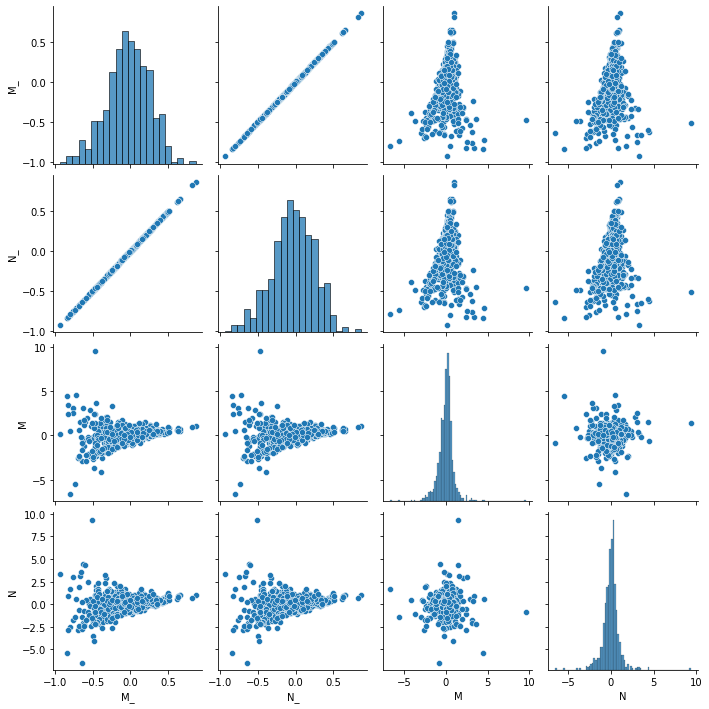

In [86]:
data_plot = pd.DataFrame({'M_': M.detach().numpy().flatten(),
                          'N_': N.detach().numpy().flatten(),
#                           'Y_': Y.detach().numpy().flatten(),
#                           'Y': train_data.Y.numpy().flatten(),
                          'M': train_data.M.numpy().flatten(),
                          'N': train_data.N.numpy().flatten()})
import seaborn as sns
sns.pairplot(data_plot)

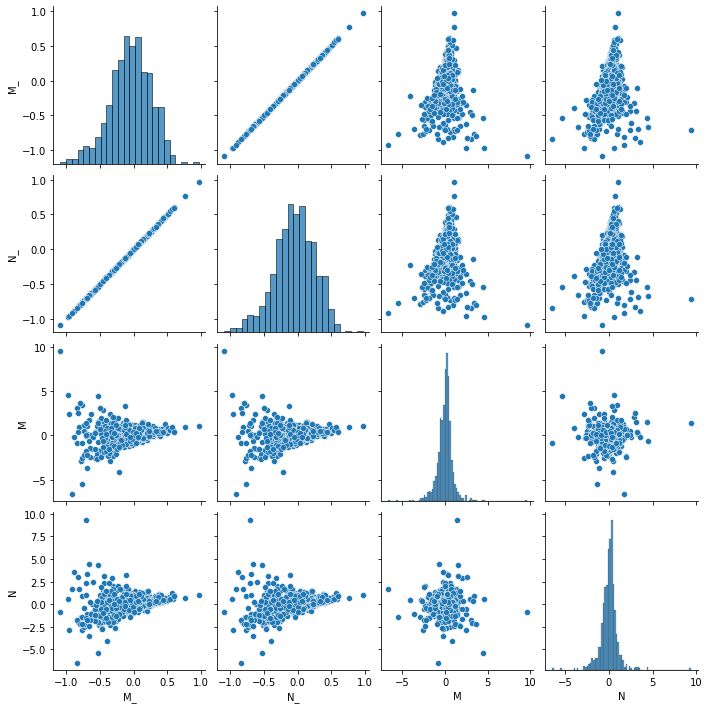

In [80]:
data_plot = pd.DataFrame({'M_': M.detach().numpy().flatten(),
                          'N_': N.detach().numpy().flatten(),
#                           'Y_': Y.detach().numpy().flatten(),
#                           'Y': train_data.Y.numpy().flatten(),
                          'M': train_data.M.numpy().flatten(),
                          'N': train_data.N.numpy().flatten()})
import seaborn as sns
sns.pairplot(data_plot)

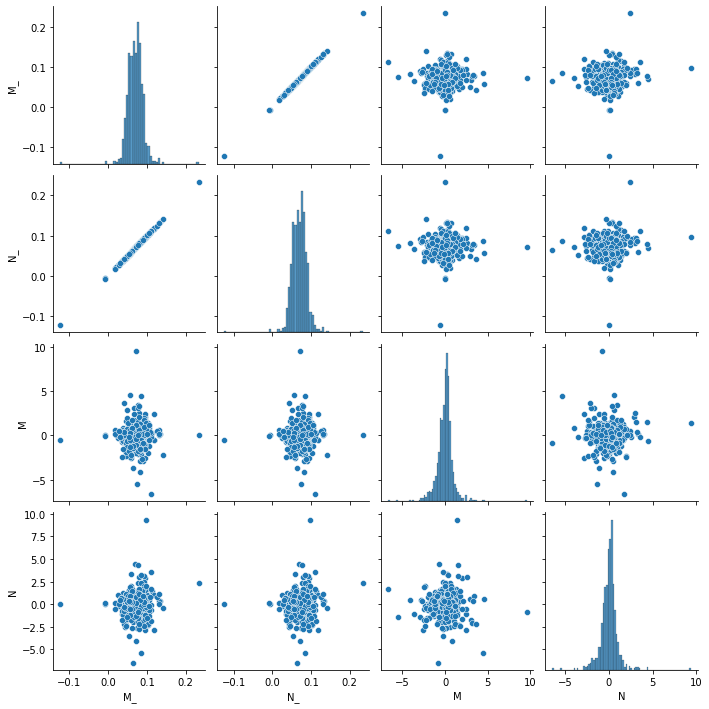

In [72]:
data_plot = pd.DataFrame({'M_': M.detach().numpy().flatten(),
                          'N_': N.detach().numpy().flatten(),
#                           'Y_': Y.detach().numpy().flatten(),
#                           'Y': train_data.Y.numpy().flatten(),
                          'M': train_data.M.numpy().flatten(),
                          'N': train_data.N.numpy().flatten()})
import seaborn as sns
sns.pairplot(data_plot)

In [16]:
train_data.Z.shape

torch.Size([743, 2])

<Figure size 432x288 with 0 Axes>

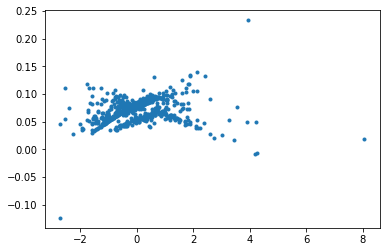

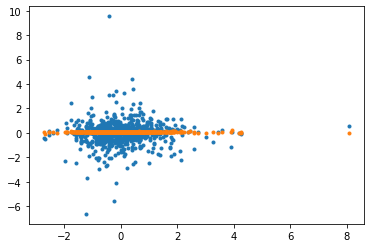

<Figure size 432x288 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt
plt.plot(train_data.Z[:, 1].detach().numpy(),X[0].detach().numpy().flatten(), '.')
plt.figure()
plt.plot(train_data.Z[:, 1].detach().numpy(),train_data.M[:, 0].detach().numpy(), '.')

plt.plot(train_data.Z[:, 1].detach().numpy(),X[0].detach().numpy().flatten(), '.')
plt.figure()

# plt.plot(np.linspace(-1.,2.,100),Y_dox.detach().numpy().flatten(), '.')



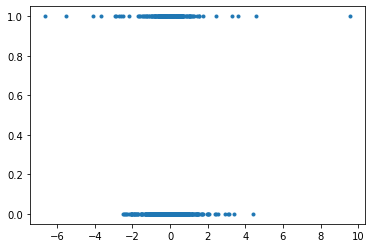

In [24]:
# sample from fitted model 


In [74]:
print(pearsonr(train_data.Z[:, 1].detach().numpy(), X[0].detach().numpy().flatten()))
print(pearsonr(train_data.Z[:, 0].detach().numpy(), X[0].detach().numpy().flatten()))

print(pearsonr(train_data.M[:, 0].detach().numpy(), M.detach().numpy().flatten()))
print(pearsonr(train_data.N[:, 0].detach().numpy(), N.detach().numpy().flatten()))


print(pearsonr(train_data.Z[:, 1].detach().numpy(), train_data.N[:, 0].detach().numpy()))



(0.1889101780725466, 2.1322032291646736e-07)
(0.15522270847359898, 2.1403368821150746e-05)
(0.057391243488949945, 0.11804634384508902)
(0.08374365021495332, 0.022438945744422765)
(0.12633993509140976, 0.0005568198405934471)


In [107]:
print(pearsonr(train_data.Z[:, 0].detach().numpy(), X[0].detach().numpy().flatten()))

print(pearsonr(train_data.Z[:, 1].detach().numpy(), train_data.M[:, 0].detach().numpy()))



(-0.0322853346824064, 0.3795195383633706)
(0.03251443949015878, 0.3761451699872394)


In [ ]:
train_data

In [48]:
train_data.Z.min()

tensor(-0.5499, dtype=torch.float64)

In [54]:
train_data.X = X[0].detach()

In [56]:
train_data.Y.shape

torch.Size([743, 1])

In [52]:
train_data.keys()

dict_keys(['M', 'N', 'Z', 'Y_covariate', 'U', 'Y', 'X'])

In [57]:
train_data.keys()
train_data_np = dotdict({})
for var in ['M', 'N', 'Z', 'Y_covariate', 'U', 'Y', 'X']:
    dat_np = train_data[var].numpy()
    if dat_np.shape[1] == 1:
        train_data_np[var] = dat_np.flatten()
    else:
        for i in range(dat_np.shape[1]):
            var_ = var + str(i)
            train_data_np[var_] = dat_np[:, i]

In [58]:
train_data_np.keys()

dict_keys(['M', 'N', 'Z0', 'Z1', 'Y_covariate0', 'Y_covariate1', 'Y_covariate2', 'Y_covariate3', 'Y_covariate4', 'U0', 'U1', 'Y', 'X'])

In [59]:
train_data_df = pd.DataFrame.from_dict(train_data_np)

In [61]:
train_data_df.to_csv('econ_x_gen.csv', sep=',')

In [60]:
train_data_df.head()

,M,N,Z0,Z1,Y_covariate0,Y_covariate1,Y_covariate2,Y_covariate3,Y_covariate4,U0,U1,Y,X
0,-0.037037,0.019637,-0.079653,-0.107587,0.662,0.783282,0.6122,8.933400,2.370244,540.0,1.0,1.0,-0.012617
1,0.044615,-0.037037,0.155680,-0.079653,0.662,0.783282,0.6122,8.959697,2.370244,540.0,2.0,1.0,-0.002838
2,-0.008837,0.044615,-0.034482,0.155680,0.662,0.783282,0.6122,8.985946,2.370244,540.0,3.0,1.0,0.001794
3,0.026746,-0.008837,0.059925,-0.034482,0.662,0.783282,0.6122,9.012134,2.370244,540.0,4.0,1.0,-0.004069
4,0.028944,0.026746,-0.018277,0.059925,0.662,0.783282,0.6122,9.035987,2.370244,540.0,5.0,1.0,-0.002280


In [32]:
%debug

> <ipython-input-20-6c4f6c8baf16>(102)forward()
    100 
    101     def forward(self, idx):
--> 102         z = self.data.Z[idx]
    103         z_feature = self.z_feature(z)
    104         pxz_mean = self.z_mean_fc(z_feature)

ipdb> type(idx)
<class 'torch.Tensor'>
ipdb> idx[0]
tensor(0., dtype=torch.float64)
ipdb> self.data.Z[0]
tensor([-0.0797, -0.1076], dtype=torch.float64)
ipdb> self.data.Z[idx]
*** IndexError: tensors used as indices must be long, byte or bool tensors
ipdb> idx.shape
torch.Size([743])
ipdb> idx = np.arange(743)
ipdb> idx[0]
0
ipdb> idx = torch.tensor(idx)
ipdb> idx[0]
tensor(0)
ipdb> self.data.Z[idx]
tensor([[-0.0797, -0.1076],
        [ 0.1557, -0.0797],
        [-0.0345,  0.1557],
        ...,
        [ 0.0444,  0.5136],
        [-0.1815,  0.0444],
        [ 0.0944, -0.1815]], dtype=torch.float64)
ipdb> exit


In [ ]:
lvm = train2(lvm, data, batch_size=64)

In [ ]:
# sample from lvm for x
q_mean, q_scale, H_q = lvm.encoder(torch.tensor(np.arange(data.Z.shape[0])[:, np.newaxis]))
q_dist = torch.distributions.Normal(q_mean, q_scale)
x_samples_from_q = q_dist.rsample()

data.X_hidden = x_samples_from_q.detach().numpy()


